In [1]:
import math
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

In [2]:
##### USER INPUT 1: READ INPUT DATA #####
master_df = pd.read_csv('master_df.csv')
master_df['WSG_Adopted'][pd.isnull(master_df['WSG_Adopted'])] = False # data cleaning

##### USER INPUT 2: DECLARE COLUMNS TO BE USED FOR X-AXIS, SIZE, AND COLOR #####
source_cols = {'x-coordinate': 'Average_Salary',
               'size': 'Size_Group',
               'color': 'WSG_Adopted'}

##### USER INPUT 3: stores number of dimensions in categorical variables (size, color)
dimensions = {'size': ["Micro", "Small-Medium", "Large"],
              'color': [True, False]}

##### USER INPUT 4: DECLARE FILL AND LABEL COLORS, AND RADII (TO BE USED IF PLOTTING) #####
edge_color = '#355C7D'
fill_colors = ['#FFFFFF','#355C7D']
label_colors = ['black','white']
radii = [0.04, 0.08, 0.16]

assert len(dimensions['size']) == len(set(master_df[source_cols['size']])), "Number of size dimensions specified does not equal number of unique values in size column"
assert len(dimensions['color']) == len(set(master_df[source_cols['color']])), "Number of color dimensions specified does not equal number of unique values in color column"
assert len(fill_colors) == len(dimensions['color']), "Number of fill colors specified does not equal number of color dimensions"
assert len(label_colors) == len(dimensions['color']), "Number of label colors specified does not equal number of color dimensions"
assert len(radii) == len(dimensions['size']), "Number of radii specified does not equal number of size dimensions"

/tmp/ipykernel_10890/3425171890.py:2: DtypeWarning: Columns (85,88,90,91,92,94,95,98,99,160,161,162,169) have mixed types. Specify dtype option on import or set low_memory=False.
  master_df = pd.read_csv('master_df.csv')
/tmp/ipykernel_10890/3425171890.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['WSG_Adopted'][pd.isnull(master_df['WSG_Adopted'])] = False # data cleaning


In [3]:
def compute_ycoord(x_curr, r_curr, existing_circles):
    """
    Function to compute the y-coordinate of a circle given its x-coordinate, radius, and the (x,y,r) details of all the circles that have been plotted before it
    The idea is to choose a y-coordinate that reduces the total entropy of the set of circles plotted
    
    Input Params
    x_curr: x-coordinate of the current circle (to be plotted)
    r_curr: radius of the current circle (to be plotted)
    existing_circles: array containing (x,y) coordinates and radius of each circle that has been plotted already (i.e. cannot be overlapped with)
    
    Output Params
    y_curr: y-coordinate of the current circle
    """
    # initialize y-coordinate at zero
    y_curr = 0
    prev_ys, deviations = (np.zeros(len(existing_circles)) for i in range(2))
    
    # add spacing
    spacing = 0.01
    for ic, circle in enumerate(existing_circles):
        x_prev, y_prev, r_prev = circle
        c2 = (r_curr + r_prev + spacing)**2 # squared sum of radii
        a2 = (abs(x_prev - x_curr + spacing))**2 # squared distance between centers of circles
        b2 = c2 - a2
        if b2 > 0:
            # if within range of any existing circle, store the y position of circle and required deviation
            prev_ys[ic] = y_prev
            deviations[ic] = np.sqrt(b2)
    
    possible_ys = [prev_ys[ix] + sign*deviations[ix] for ix in range(len(prev_ys)) for sign in [-1,1]]
    # choose the possible y closest to zero
    if abs(min(possible_ys)) < max(possible_ys):
        y_curr = min(possible_ys)
    else:
        y_curr = max(possible_ys)
    
    # iterate through intermediate y coordinates between 0 and y_curr to find suitable gaps
    ymid = 0
    for loop in range(int(abs(y_curr)/0.01)):
        delta = [abs(prev_ys[i] - ymid) - deviations[i] for i in range(len(prev_ys))]
        if min(delta) <= 0:
            ymid += np.sign(y_curr)*0.01
    
    if abs(ymid) < abs(y_curr):
        y_curr = ymid
    
    return y_curr

In [4]:
def discretize(x, xbins):
    """
    Function to discretize input data, x, into specified bins, bounded by xbins
    Returns indices of input data corresponding to each bin
    
    Input Params
    x: input data, series or array
    xbins: an array specifying the starts and ends of each bin into which the input dataset is to be discretized
    
    Output Params
    idxs: an array of indices of length xbins-1 that
    """
    assert len(x) >= len(xbins)-1, "Length of input data, x, is smaller than the number of bins into which it must be discretized."
    
    indexes = []
    for ix in range(len(xbins)-2):            
        # if xbin[ix] >= x > xbin[ix+1]
        indexes.append(x.index.values[(x <= xbins[ix]) & (x > xbins[ix+1])])
    indexes.append(x.index.values[(x <= xbins[len(xbins)-1])])
    
    return indexes

In [5]:
import os
os.chdir('bubble_data')

In [6]:
ITMs = np.unique(master_df['ITM'])

for ITM in ITMs:
    extract_df = master_df[(master_df['ITM'] == ITM) & (master_df[source_cols['x-coordinate']] > 0)]
    
    # filter 5th to 95th percentile
    temp_df = extract_df[(extract_df[source_cols['x-coordinate']] > extract_df[source_cols['x-coordinate']].quantile(0.05)) &
                         (extract_df[source_cols['x-coordinate']] < extract_df[source_cols['x-coordinate']].quantile(0.95))].reset_index()
    
    # isolate columns of interest & sort by increasing x-coordinate
    temp_df = temp_df.sort_values(by = [source_cols['x-coordinate']], ascending = False).reset_index()
    retain_cols = ['Average_Salary', 'Size_Group', 'WSG_Adopted', 'entity_name', 'ID', 'ITM', 'ID_ITM']
    temp_df = temp_df[retain_cols]
    
    N = min(len(temp_df), 225)
    indexes = {}
    circles = pd.DataFrame(columns = ['x-coordinate','y-coordinate','size','color','counts','names','x_min','x_max'])
    for size in dimensions['size']:
        for color in dimensions['color']:
            # isolate size x color group, sort by increasing x-coordinate
            subgroup = temp_df[(temp_df[source_cols['size']] == size) &
                               (temp_df[source_cols['color']] == color)]
            
            # determine xbins for using x-coordinate range
            proportion = len(subgroup.index)/len(temp_df.index)
            nbins = int(round(N*proportion, 0))
            if nbins < 1:
                continue
            steps = len(subgroup.index)/nbins
            
            xbins = np.asarray(subgroup.iloc[[int(ix*steps) for ix in range(nbins)],
                                             subgroup.columns.get_loc(source_cols['x-coordinate'])])
            min_x = min(subgroup[source_cols['x-coordinate']]) 
            xbins = np.append(xbins, min_x)
            
            # discretize and store indexes
            indexes = discretize(subgroup[source_cols['x-coordinate']], xbins)
            
            # for each discrete bin:
            # 1. store size, color, and mean(x-coordinate) for each discrete bin
            # 2. store number of companies, company names, and salary range as labels
            
            for ii in indexes:
                if len(ii) < 1:
                    continue
                data = {'x-coordinate' : [np.mean(subgroup.loc[ii,source_cols['x-coordinate']])],
                        'y-coordinate' : [0],
                        'size' : size,
                        'color' : int(color),
                        'counts' : [len(ii)],
                        'names' : '\n'.join(np.asarray(temp_df.loc[ii,'entity_name'])),
                        'x_min' : round(np.min(subgroup.loc[ii,source_cols['x-coordinate']]),2),
                        'x_max' : round(np.max(subgroup.loc[ii,source_cols['x-coordinate']]),2)}
                
                circles = pd.concat([circles, pd.DataFrame(data)])
    
    # recode size column
    conditions = [
        (circles['size'] == dimensions['size'][0]),
        (circles['size'] == dimensions['size'][1]),
        (circles['size'] == dimensions['size'][2])
        ]
    circles['radius'] = np.select(conditions, radii)
    circles.sort_values(by = ['radius'], ascending = False, inplace = True)
    
    circles.iloc[:,0] = np.log10(circles.iloc[:,0]) # log axis looks better!
    # normalize x-axis: 0 - 5
    x_max = max(circles.iloc[:,0])
    x_min = min(circles.iloc[:,0])
    circles.iloc[:,0] = 5*(circles.iloc[:,0] - x_min) / (x_max - x_min)
    
    # compute y-coordinates
    plot_circles = circles[['x-coordinate','y-coordinate','radius']].to_numpy()
    for ir, row in enumerate(plot_circles):
        x_curr, y_curr, r_curr = row
        if ir > 0:
            existing_circles = plot_circles[0:ir,:]
            plot_circles[ir,1] = compute_ycoord(x_curr, r_curr, existing_circles)
            
    # replace computed y-coordinates in dataframe
    circles['y-coordinate'] = plot_circles[:,1]
    
    ##### EXPORT BUBBLE PLOT DATA #####    
    circles.to_csv(ITM + ".csv")

In [7]:
import os
os.chdir('../master_data')

In [8]:
ITMs = np.unique(master_df['ITM'])
for ITM in ITMs:
    extract_df = master_df[(master_df['ITM'] == ITM) & (master_df[source_cols['x-coordinate']] > 0)].reset_index()
    # filter 5th to 95th percentile
    temp_df = extract_df[(extract_df[source_cols['x-coordinate']] > extract_df[source_cols['x-coordinate']].quantile(0.05)) &
                         (extract_df[source_cols['x-coordinate']] < extract_df[source_cols['x-coordinate']].quantile(0.95))].reset_index()
    temp_df.to_csv(ITM + ".csv")

In [9]:
def discretize(circles, xbins):
    """
    Function to discretize input data into specified bins
    Bins are specified along the continuous dimension (i.e. x)
    There is up to one count for each size group within each bin (maximum counts = number of bins x number of size groups)
    Note: there may be fewer than the maximum counts as there could be some size x bin groups with no data points
    
    Input Params
    circles: original data with (x,y) coordinates, radius r, and an indicator for color
    xbins: an array specifying the starts and ends of each bin into which the input dataset is to be discretized
    
    Output Params
    new_circles: new array expressing GROUPINGS of original data with (x,y) coordinates, radius r, and an indicator for color
    labels: array containing the number of data points within the GROUP expressed by each row
    """
    assert len(circles[0,:]) == 4, "Input data needs to have four dimensions: x, y, radius, color"
    assert max(circles[:,3]) == min(circles[:,3]), "All data points in input data to have the same indicator for color"
    
    new_circles = np.zeros((len(xbins)*3, 4))
    labels = np.zeros((len(xbins)*3, 1))
    
    for ix in range(len(xbins)-1):
        for ir in range(len(radii)): # radii is a global variable
            
            # if x in bin and radius matches
            idxs = np.where((circles[:,0] >= xbins[ix]) &
                            (circles[:,0] < xbins[ix+1]) &
                            (circles[:,2] == radii[ir]))[0]
            labels[ix*3+ir,0] = len(idxs)
            
            # retain mean x-coordinate of circles
            new_circles[ix*3+ir,0] = np.mean(circles[:,0][idxs])
            # all circles in bin have same radius
            new_circles[ix*3+ir,2] = radii[ir]
            
    # all circles have same indicator for color
    new_circles[:,3] = circles[:,3][0]
    
    # remove empty rows
    new_circles = new_circles[(labels[:,0] > 0)]
    labels = labels[(labels[:,0] > 0)]
    
    return new_circles, labels

def condense(original_circles, N = 225):
    """
    Function to condense the total number of companies into specified number of rows (N) while preserving visual ratio of color indicator
    Binning is based on similar profiles of x-coordinate, size, and color
    If unspecified, sets N = 225
    
    Input Params
    original_circles: a mx4 array where m = total number of rows in the original dataset
    each row contains (x,y) coordinates, radius r, and an indicator for color
    N: number of rows in the output dataset; M rows will be condensed to at most N rows
    
    Output Params
    new_circles: a nx4 array where n = number of rows in the condensed dataset; note that n <= N
    each row contains (x,y) coordinates, radius r, and an indicator for color
    labels: a nx1 array containing the number of companies within the GROUP expressed by each row
    """
    assert len(original_circles[0,:]) == 4, "Input data needs to have four dimensions: x, y, radius, color"
    assert N < len(original_circles), "The original number of rows in the dataset is already smaller than N"
    assert int(N) == N, "N must be an integer"
    
    new_circles, labels = np.array([]), np.array([])
    # loop through all color dimensions
    for dd in range(0, len(dimensions['color'])):
        
        # separate by color indicator to preserve relative ratio of colors
        circles1 = all_circles[all_circles[:,3] == dimensions['color'][dd]]
        xbins = [circles1[ix*N,0] for ix in range(int(np.floor(len(circles1)/N)))]
        xbins.append(circles1[-1,0])
    
        # call DISCRETIZE to bin by groups of x, size, color
        # retain number of data points in each group as labels
        new_circles1, labels1 = discretize(circles1, xbins)
        new_circles = np.vstack([new_circles, new_circles1]) if new_circles.size else new_circles1
        labels = np.vstack([labels, labels1]) if labels.size else labels1
    
    return new_circles, labels

def add_legend(plt, textlims):
    """
    Function to add legend to the plot
    
    Input Params
    plot: matplotlib.pyplot object
    textlims: y-position of the text, marks the closest that the text can be to the plot to prevent overlapping
    
    Ouput Params
    plot: matplotlib.pyplot object
    """
    # add legend: workforce size circles
    legend1 = plt.Circle((0, (-1)*textlims-0.25), radii[0],
                         color = 'k', linewidth = 5, fill = False)
    plt.gca().add_artist(legend1)
    plt.plot([0, 0.5], [(-1)*textlims-0.25, (-1)*textlims-0.25], color = 'k', linestyle = '-', linewidth = 2)
    plt.text(0.55, (-1)*textlims-0.275, "< 10 [MICRO]", fontsize = 18)

    legend2 = plt.Circle((0, (-1)*textlims-0.25+radii[1]-radii[0]), radii[1],
                         color = 'k', linewidth = 5, fill = False)
    plt.gca().add_artist(legend2)
    plt.plot([0, 0.5], [(-1)*textlims-0.25+radii[1]-radii[0]+radii[1], (-1)*textlims-0.25+radii[1]-radii[0]+radii[1]],
             color = 'k', linestyle = '-', linewidth = 2)
    plt.text(0.55, (-1)*textlims-0.275+radii[1]-radii[0]+radii[1], "10 to < 200 [SMALL-MEDIUM]", fontsize = 18)

    legend3 = plt.Circle((0, (-1)*textlims-0.25+radii[2]-radii[0]), radii[2],
                         color = 'k', linewidth = 5, fill = False)
    plt.gca().add_artist(legend3)
    plt.plot([0, 0.5], [(-1)*textlims-0.25+radii[2]-radii[0]+radii[2], (-1)*textlims-0.25+radii[2]-radii[0]+radii[2]],
             color = 'k', linestyle = '-', linewidth = 2)
    plt.text(0.55, (-1)*textlims-0.275+radii[2]-radii[0]+radii[2], r"$\geq$ 200 [LARGE]", fontsize = 18)

    plt.text(-0.25, (-1)*textlims+0.2, "Median Local Workforce Size", fontsize = 24, weight = 'bold')

    # add legend: adoption of >= 1 WSG programme
    rect = mpatches.Rectangle((-0.25, (-1)*textlims-0.52), 0.25, 0.1, facecolor = edge_color)
    plt.gca().add_patch(rect)
    plt.text(0.05, (-1)*textlims-0.5, r"WSG Programme Adopters", fontsize = 24, weight = 'bold')
    
    return plt

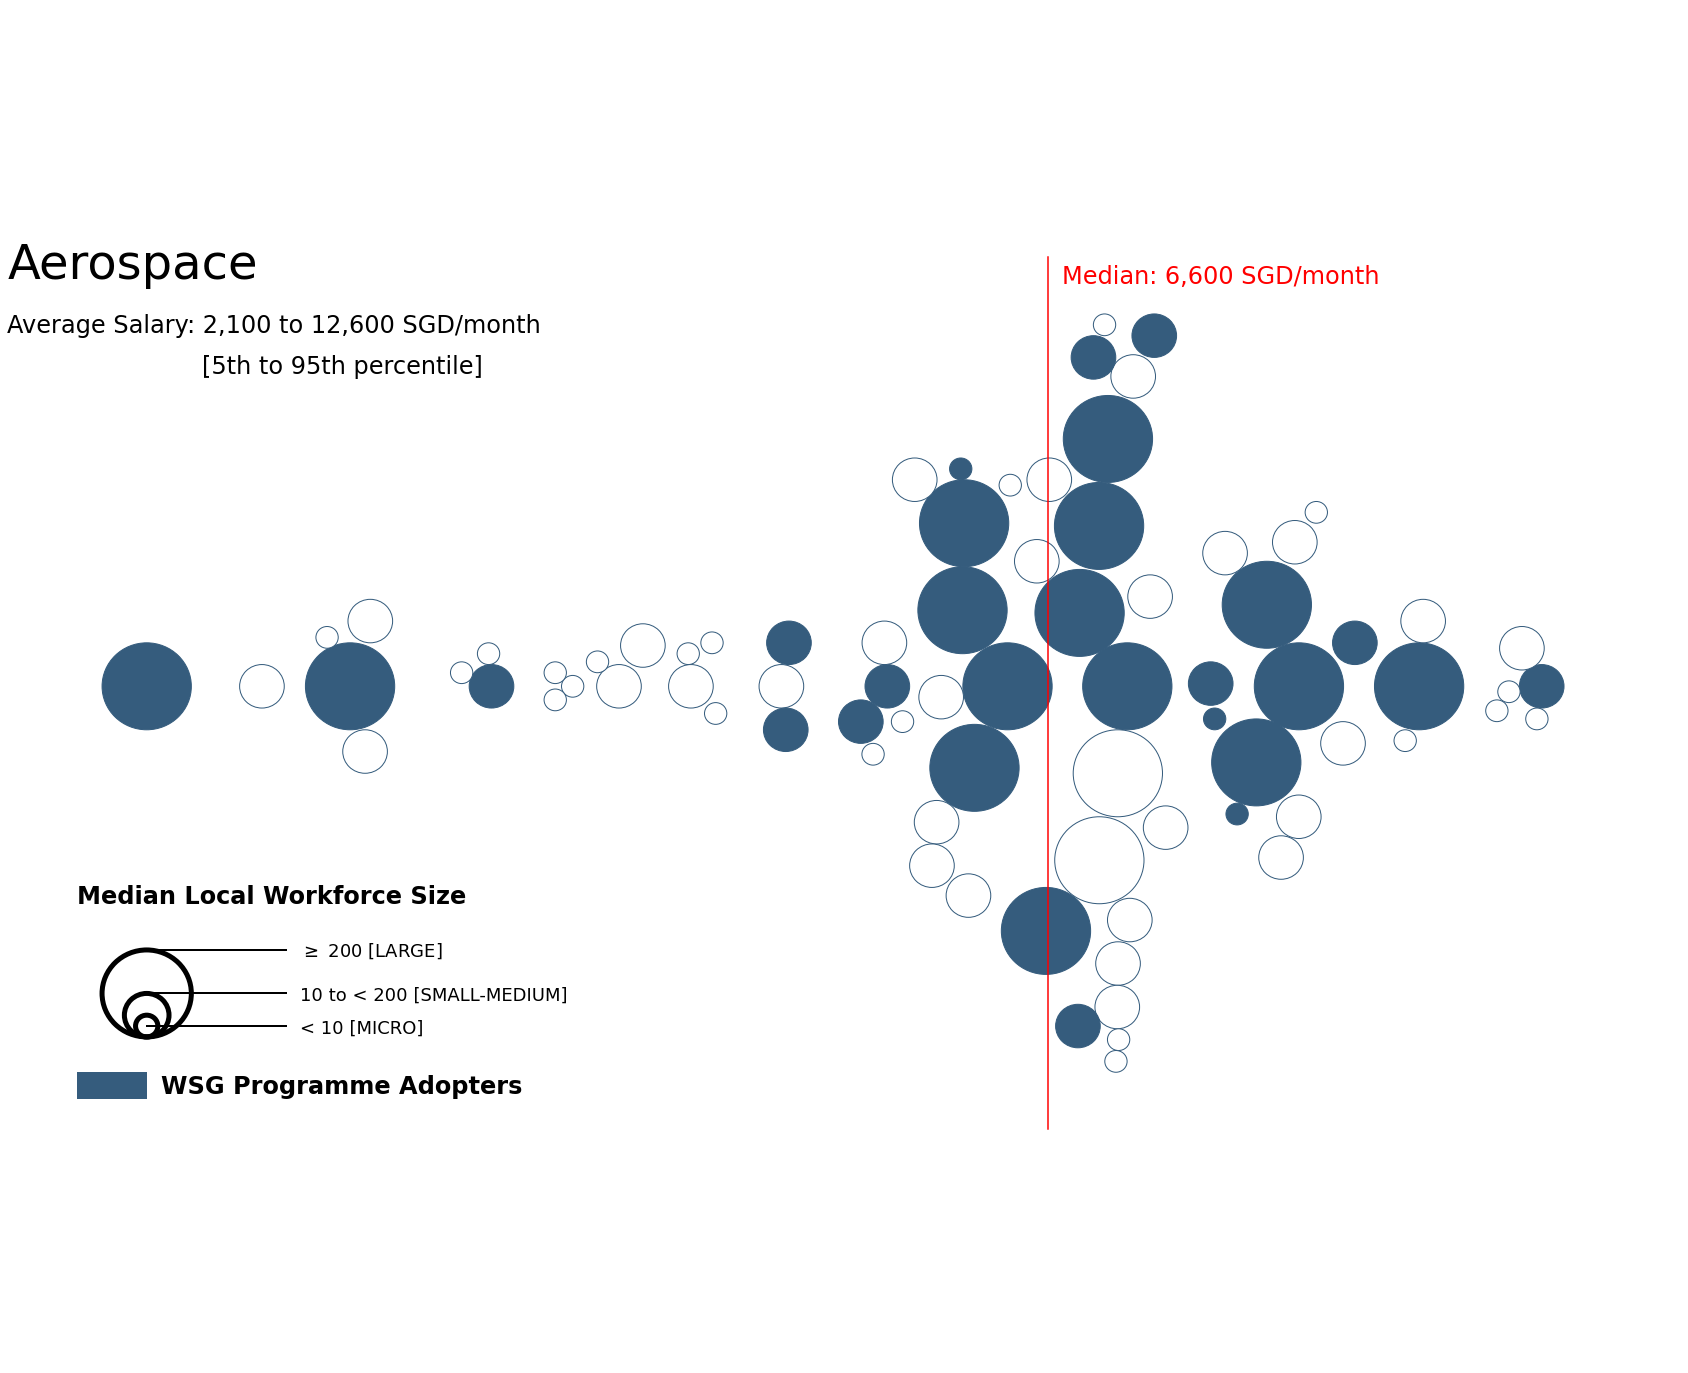

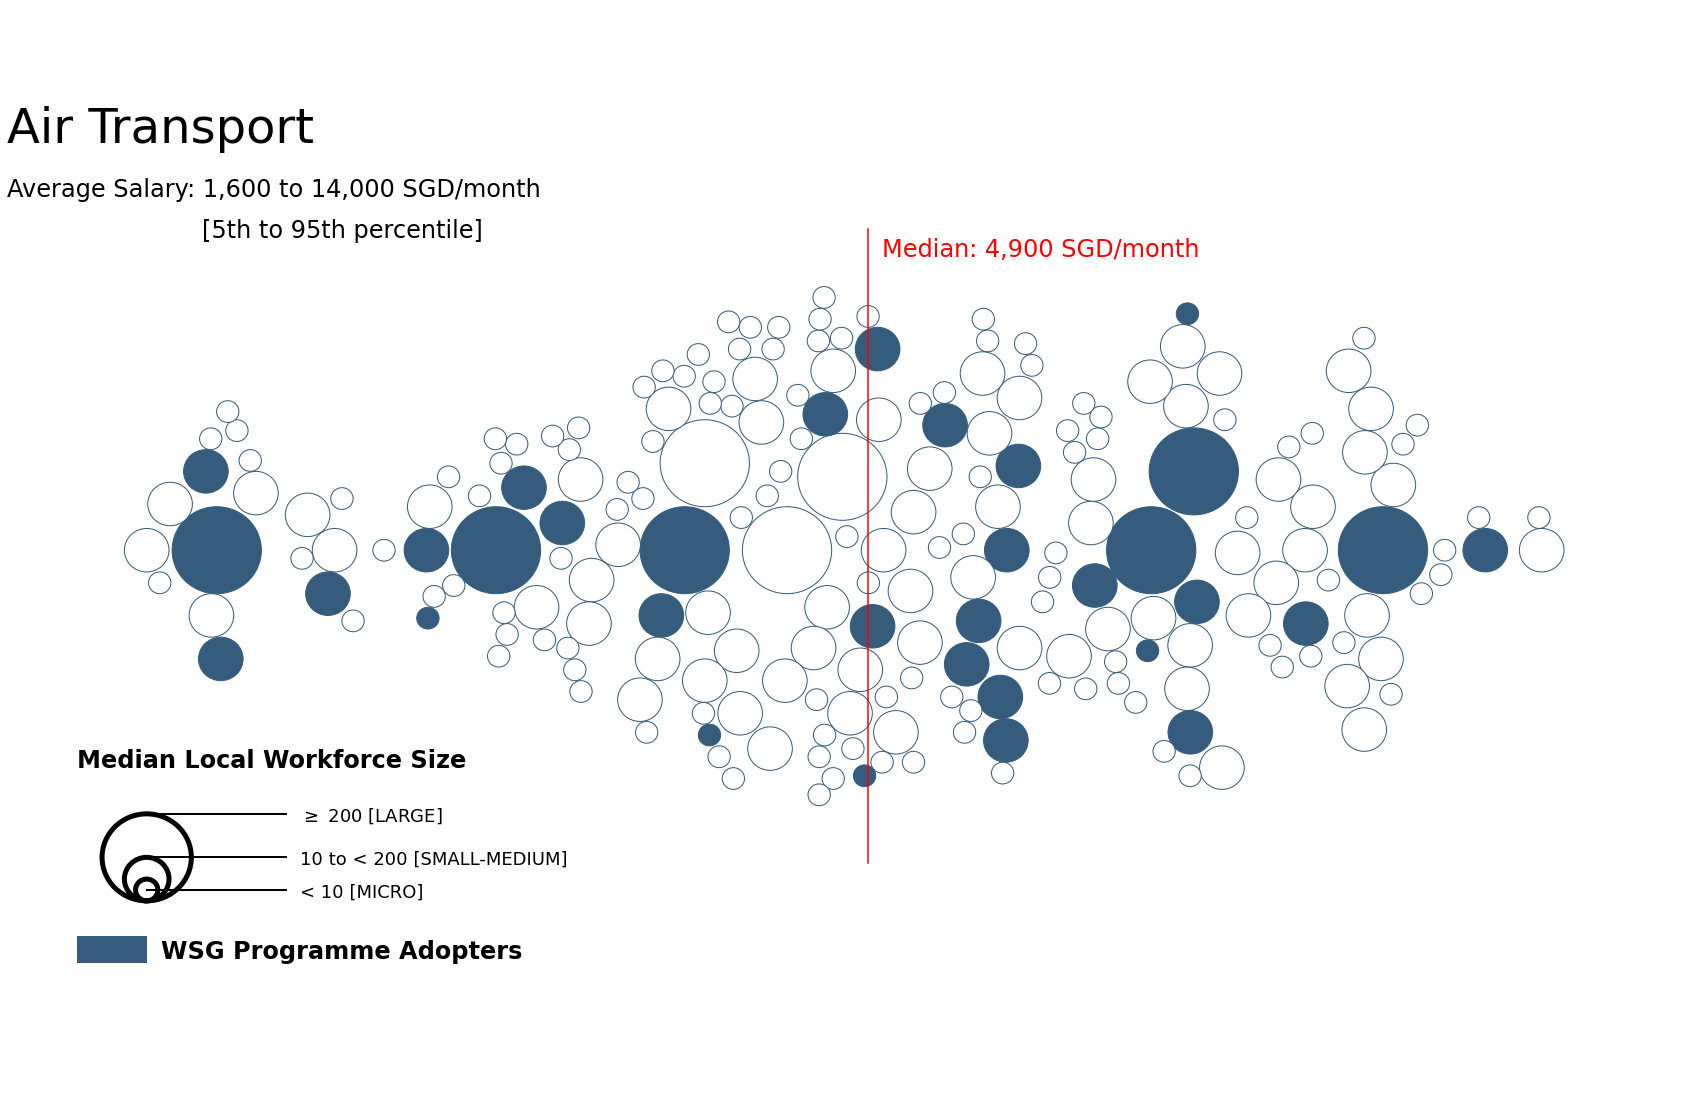

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


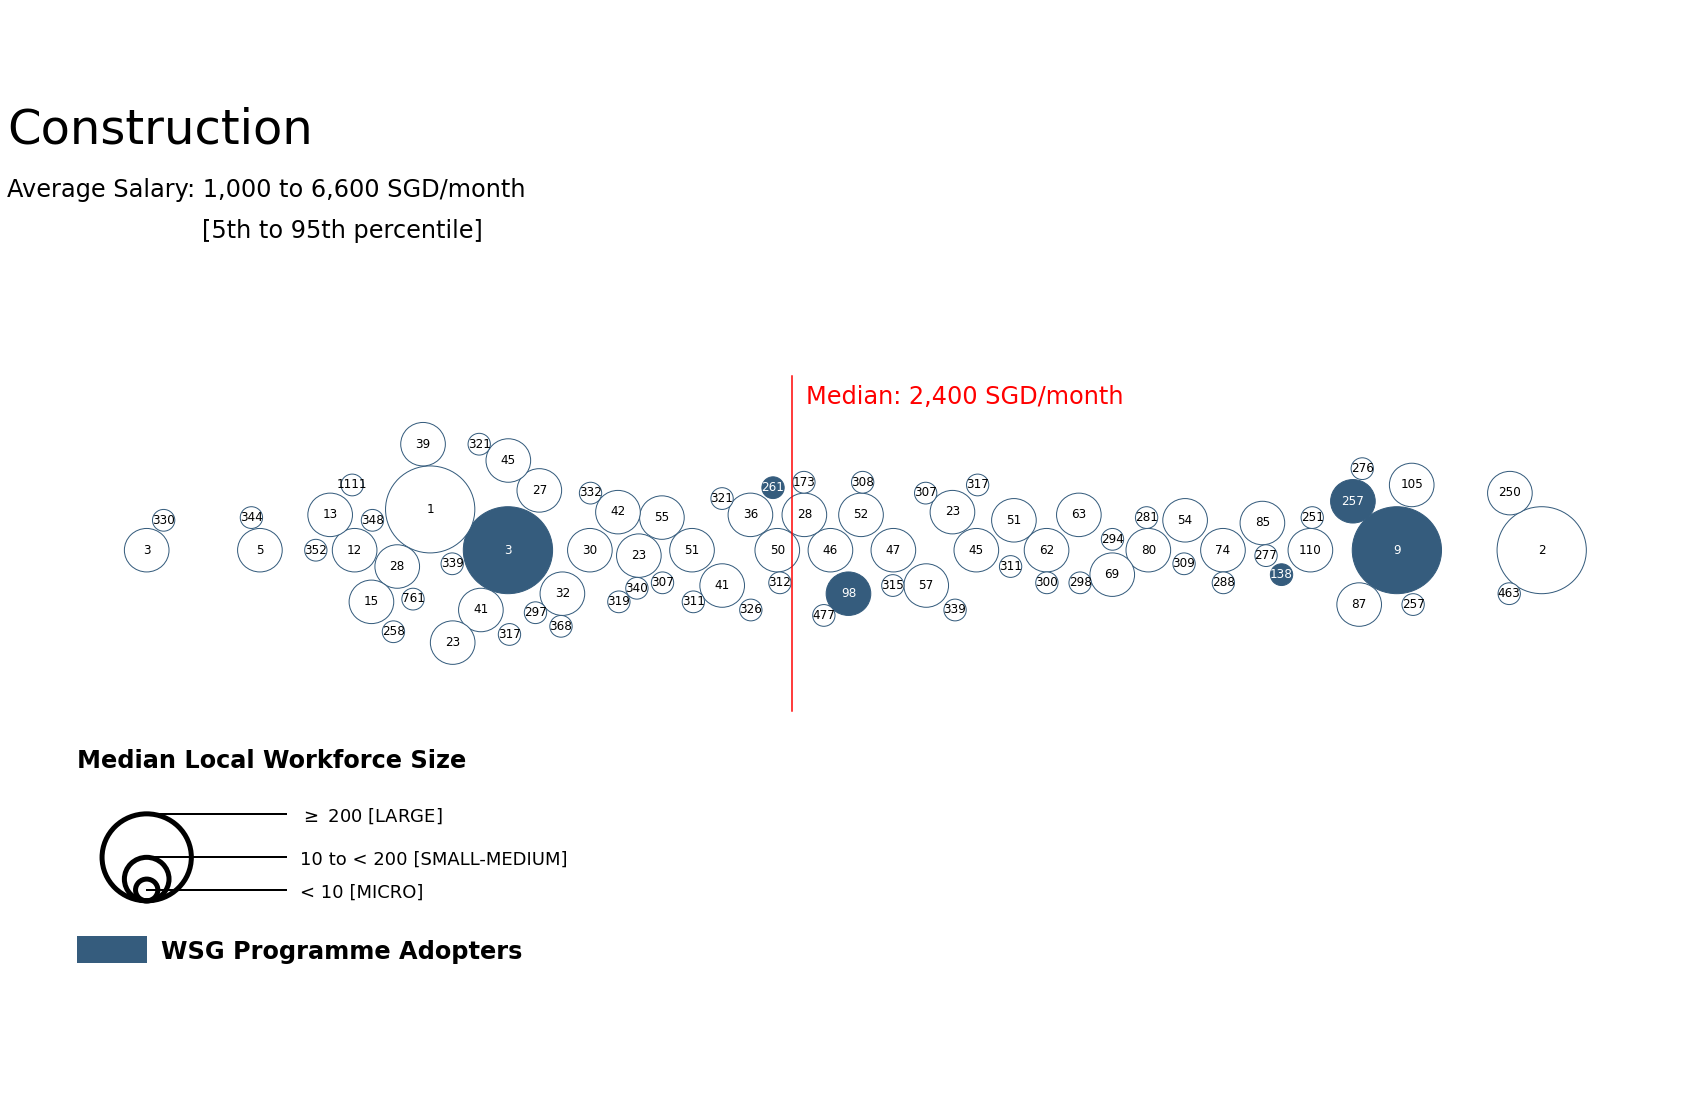

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


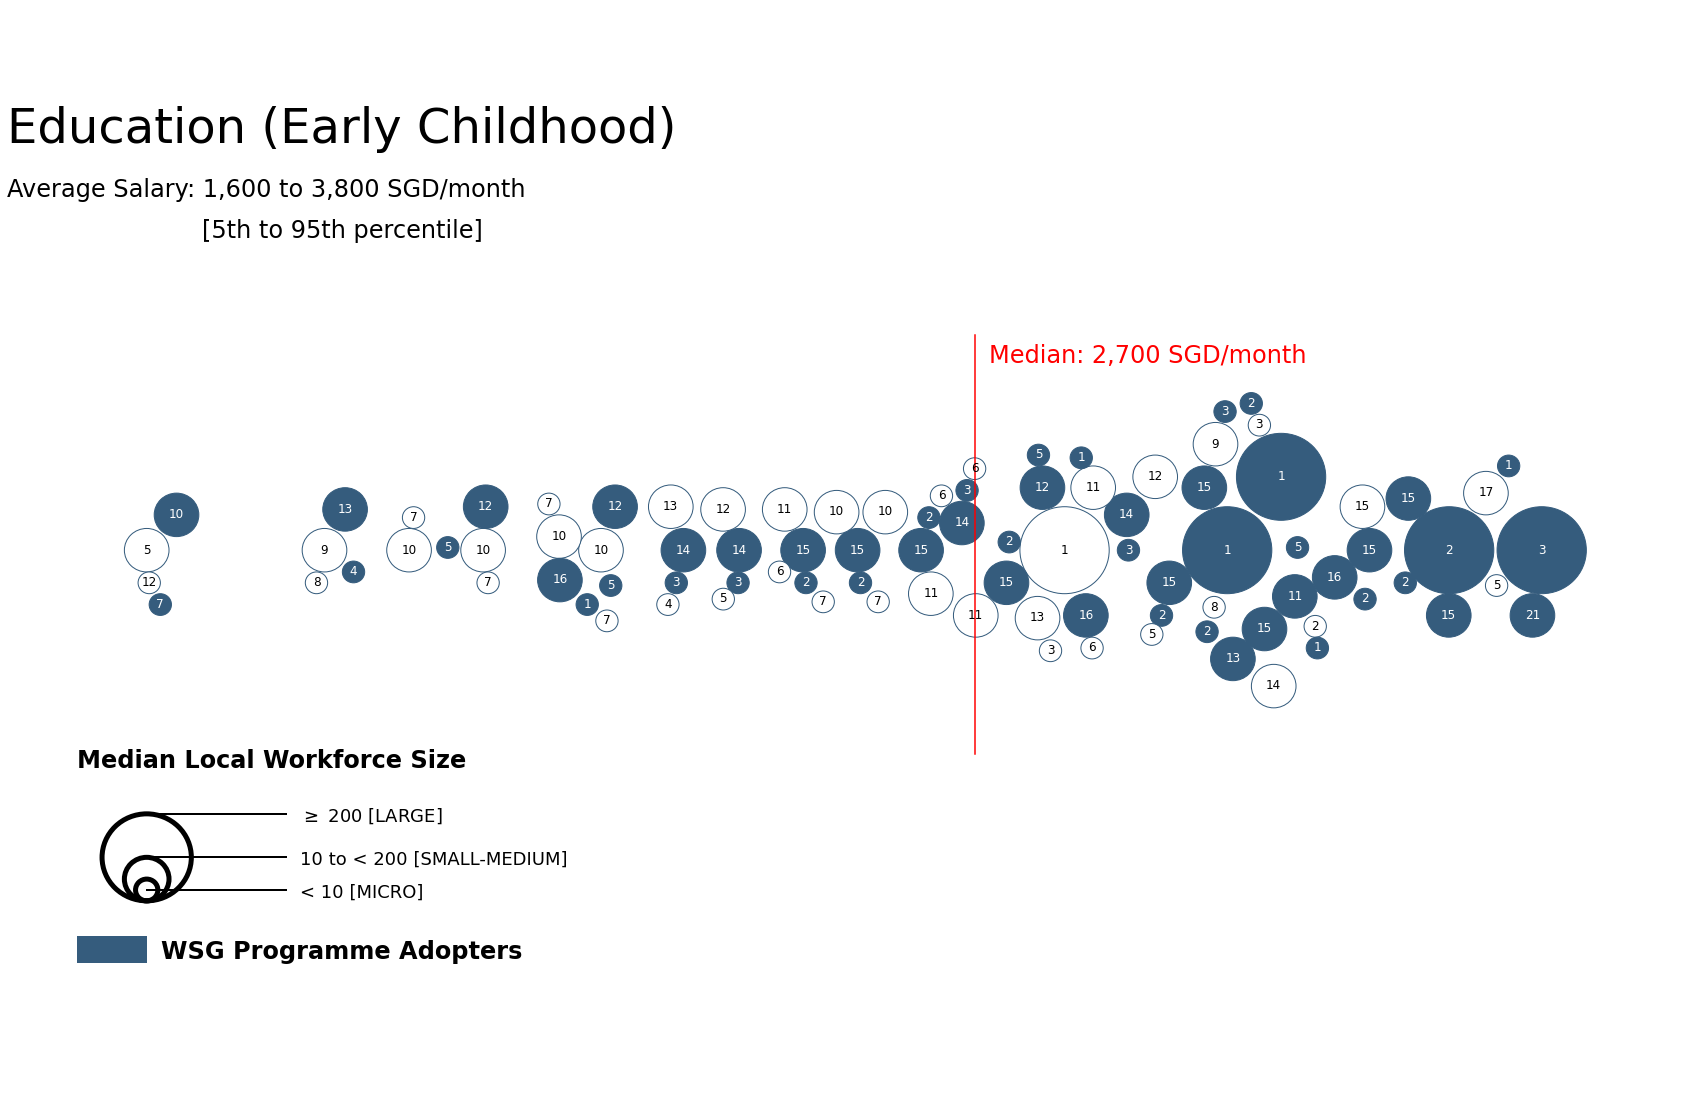

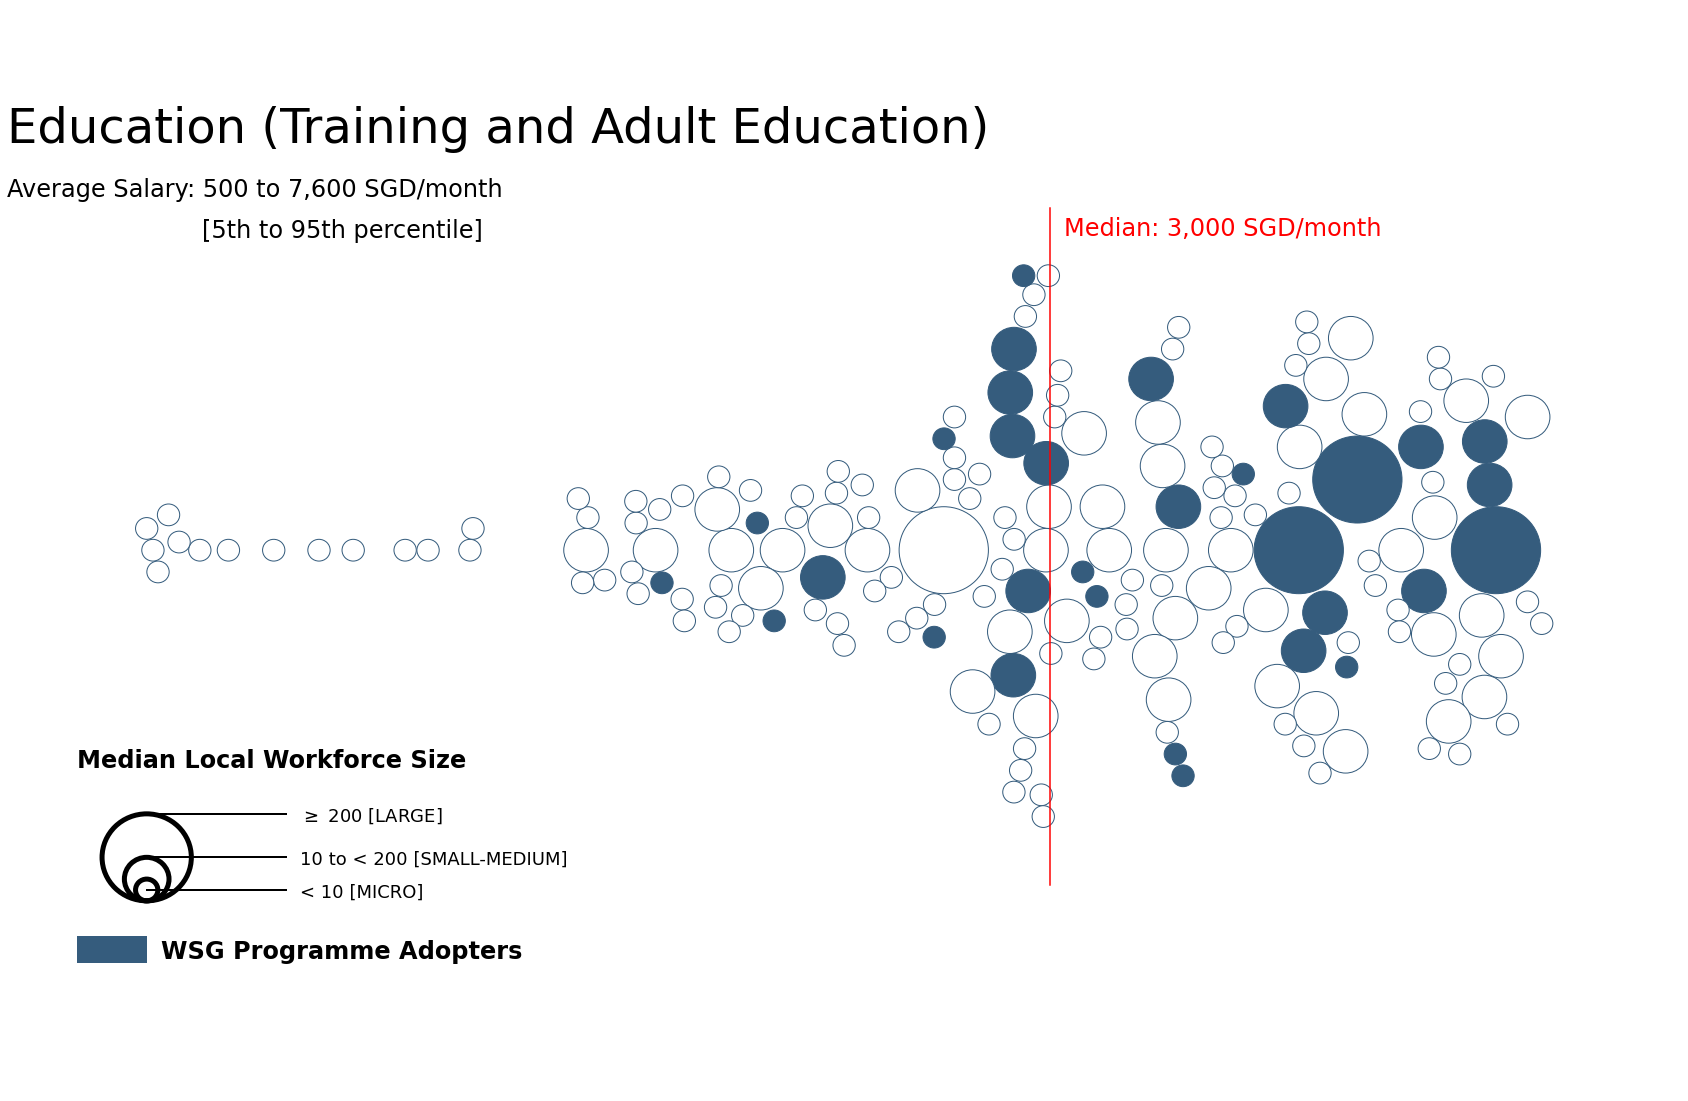

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


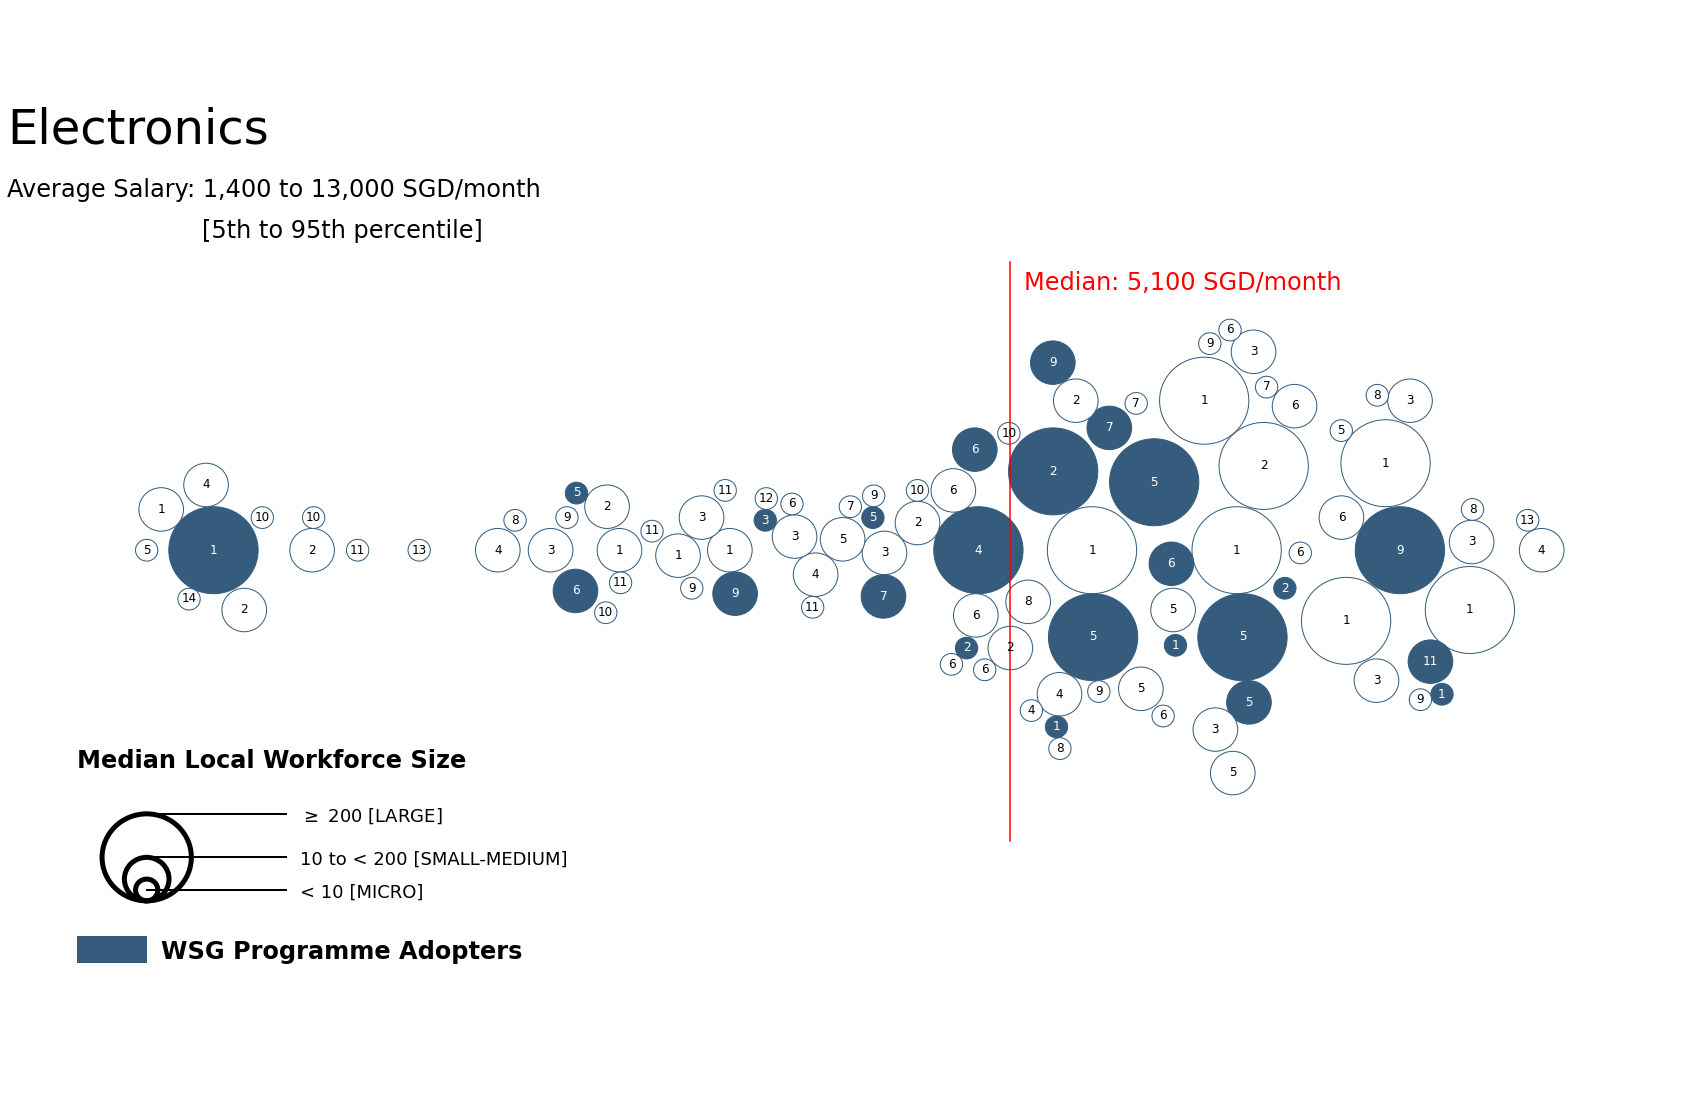

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


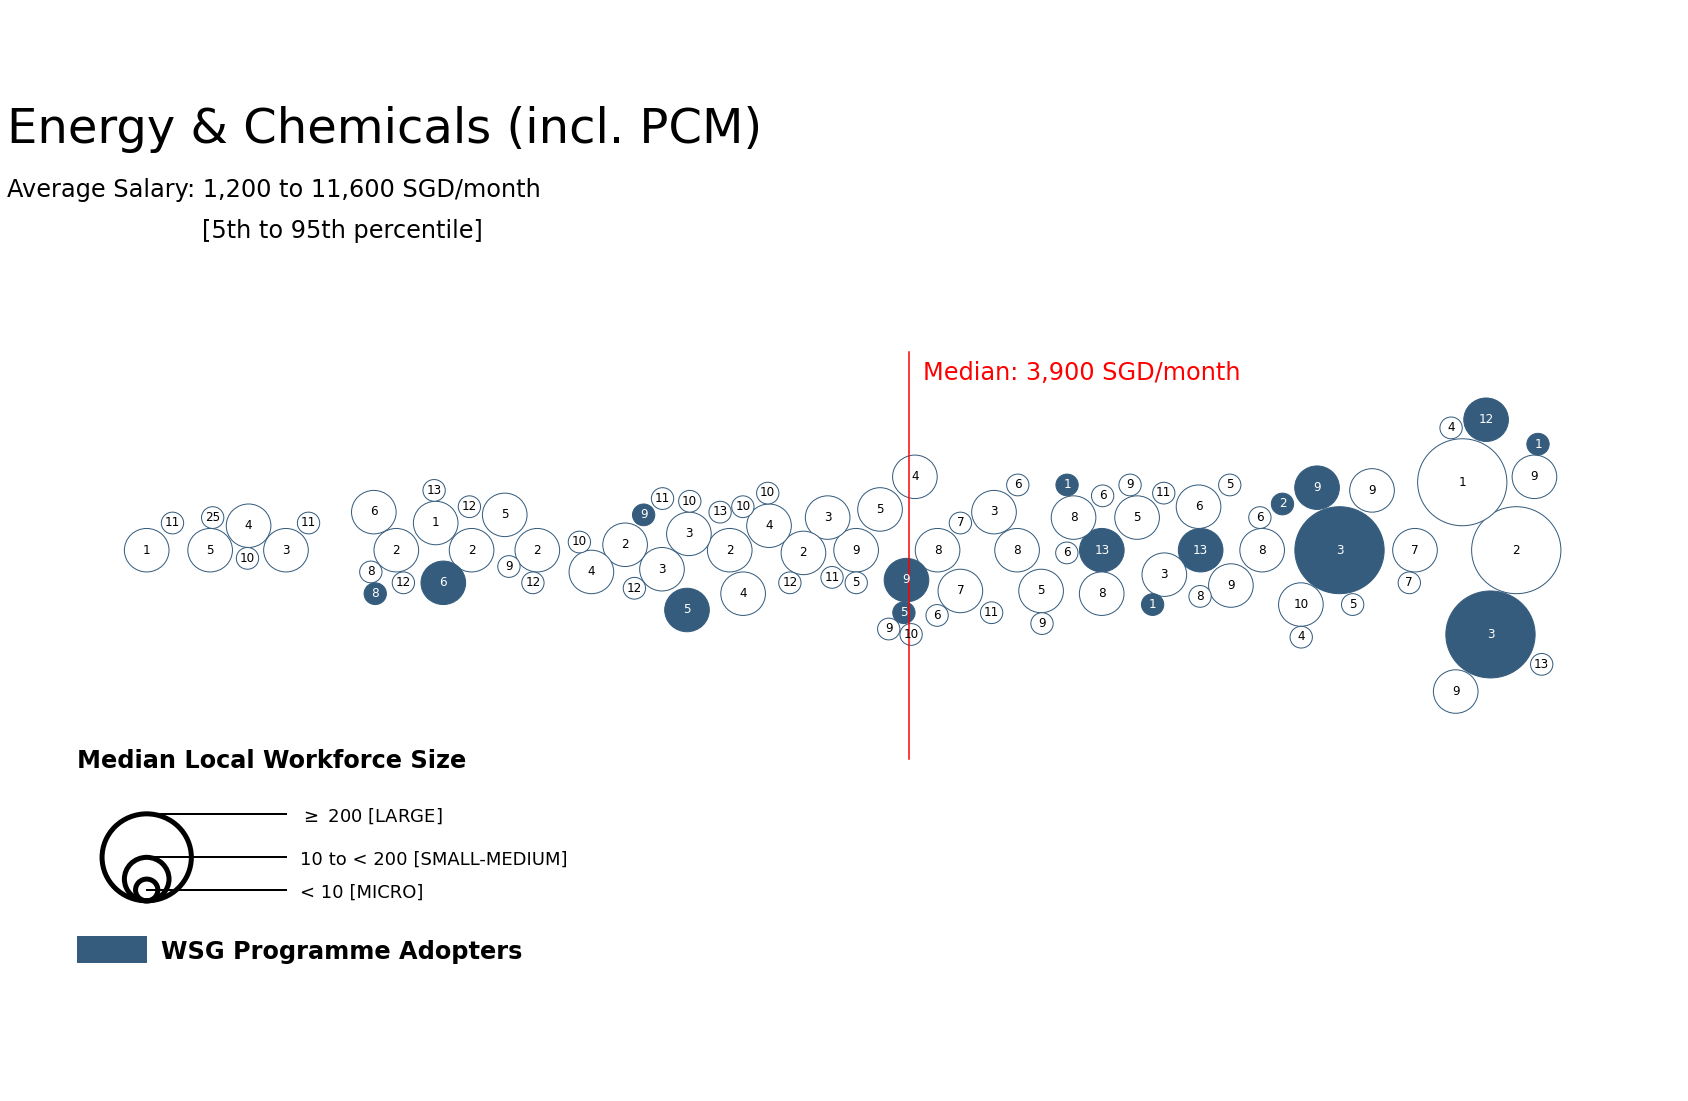

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


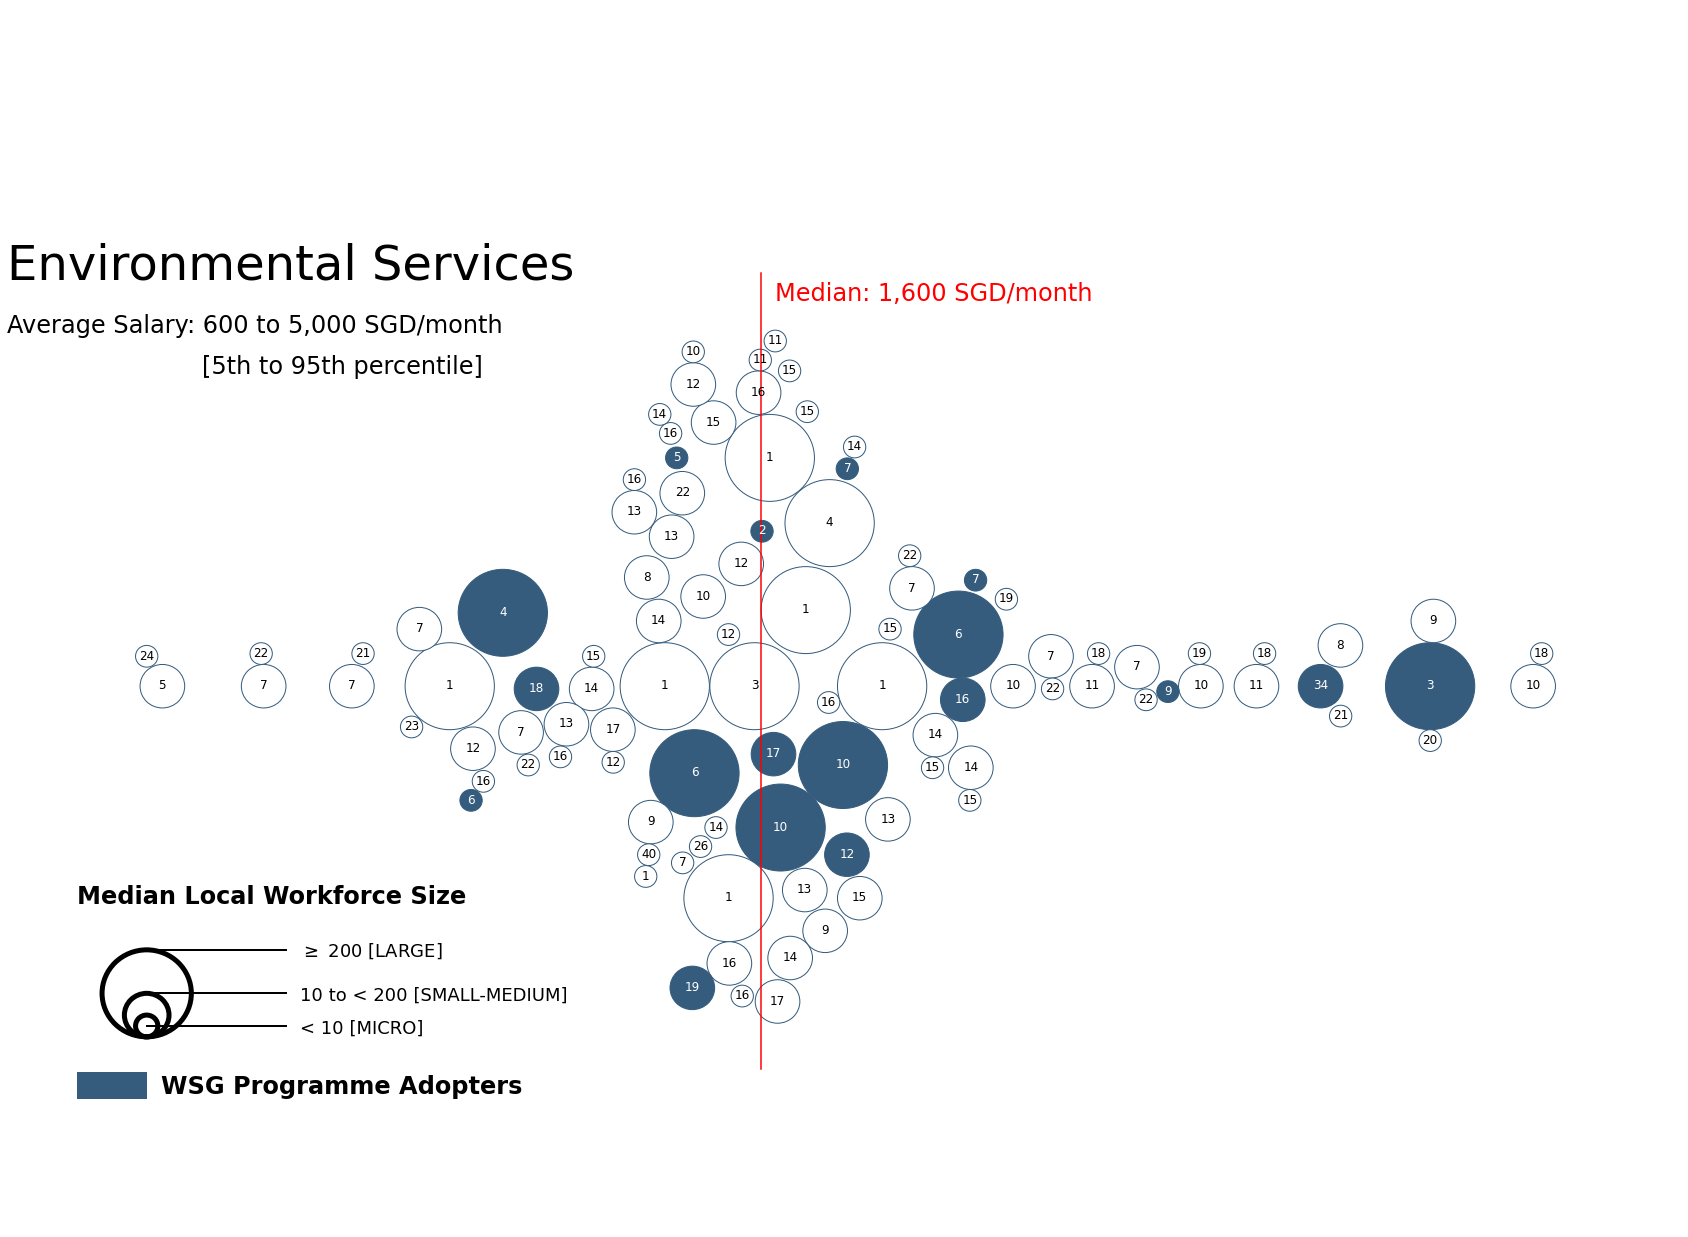

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


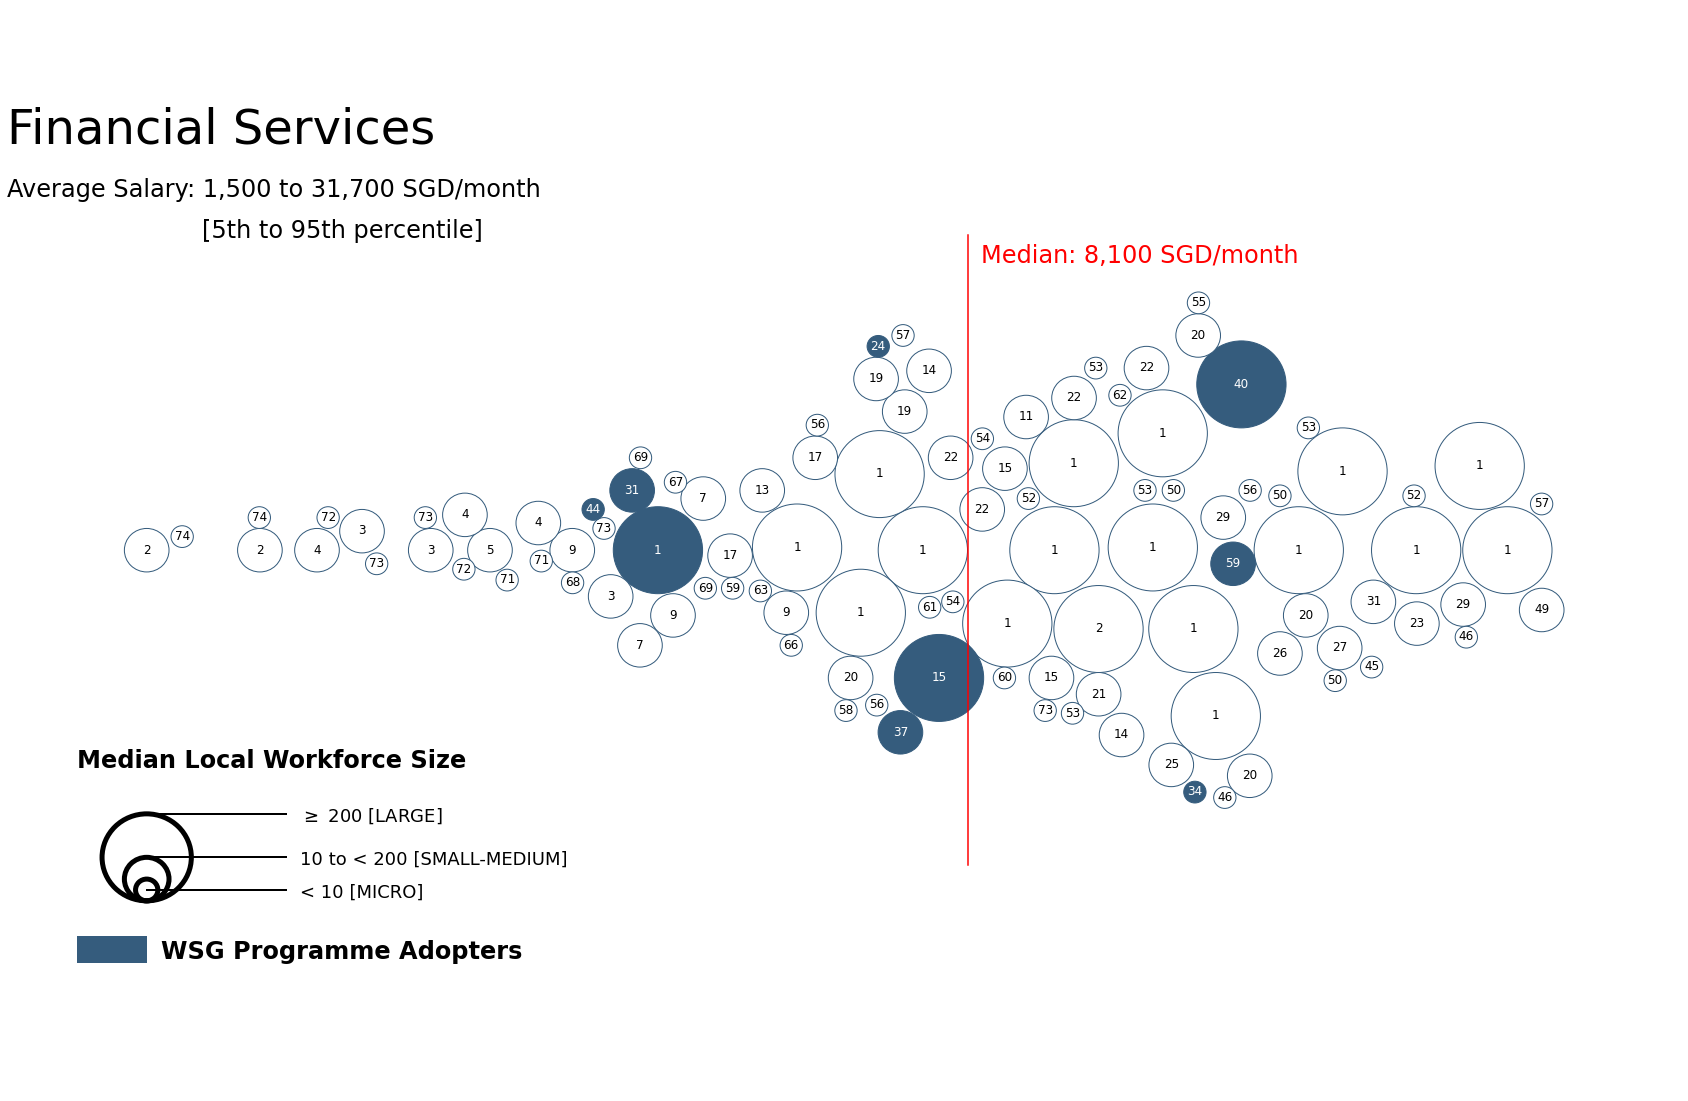

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


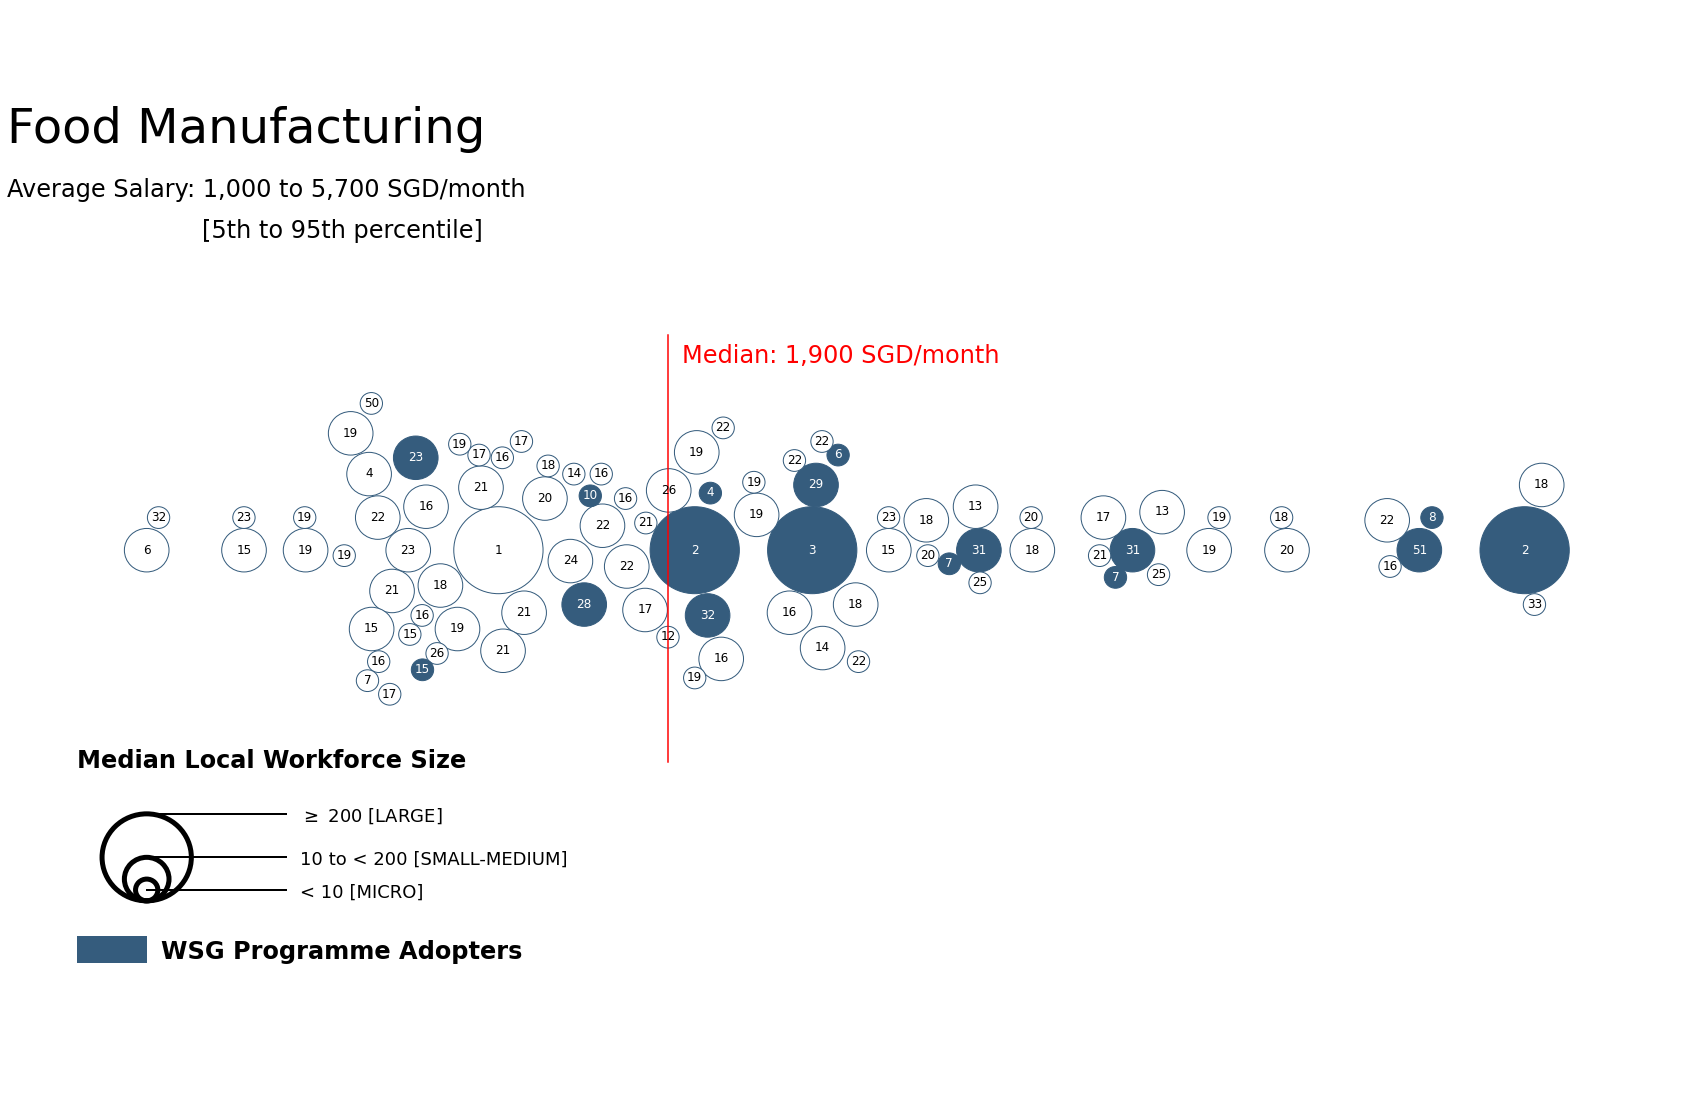

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


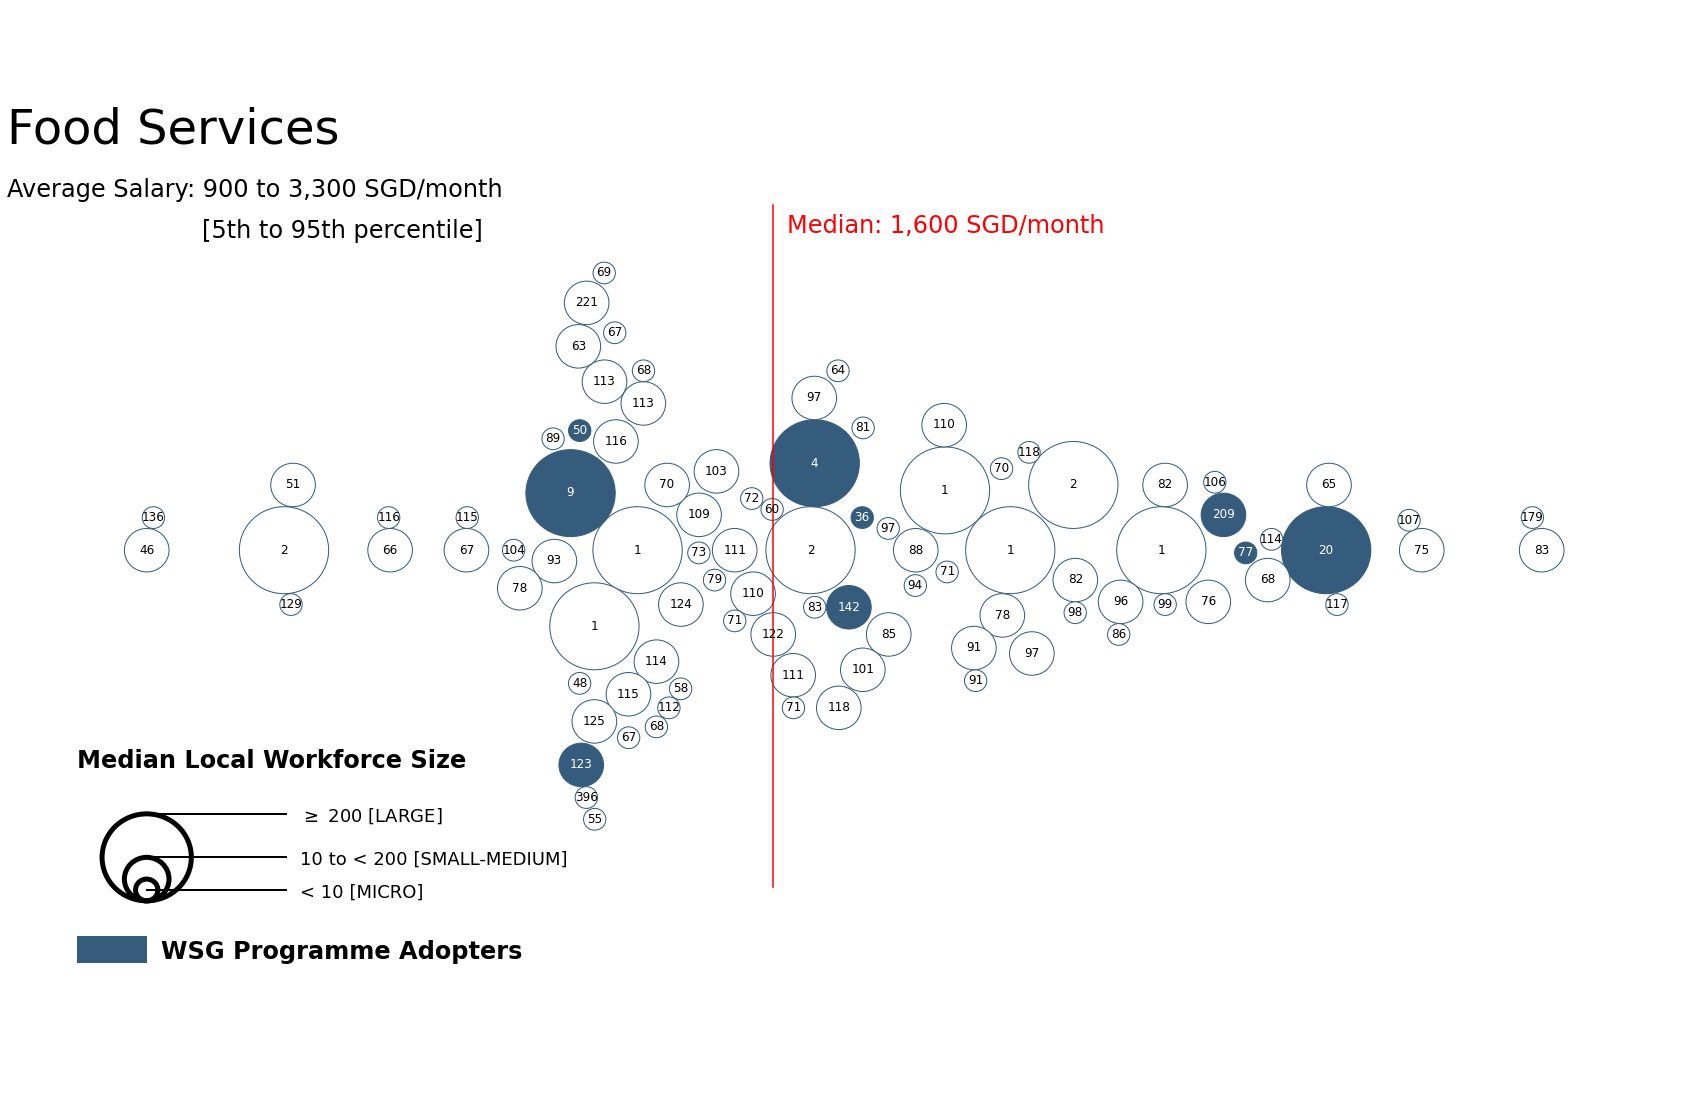

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


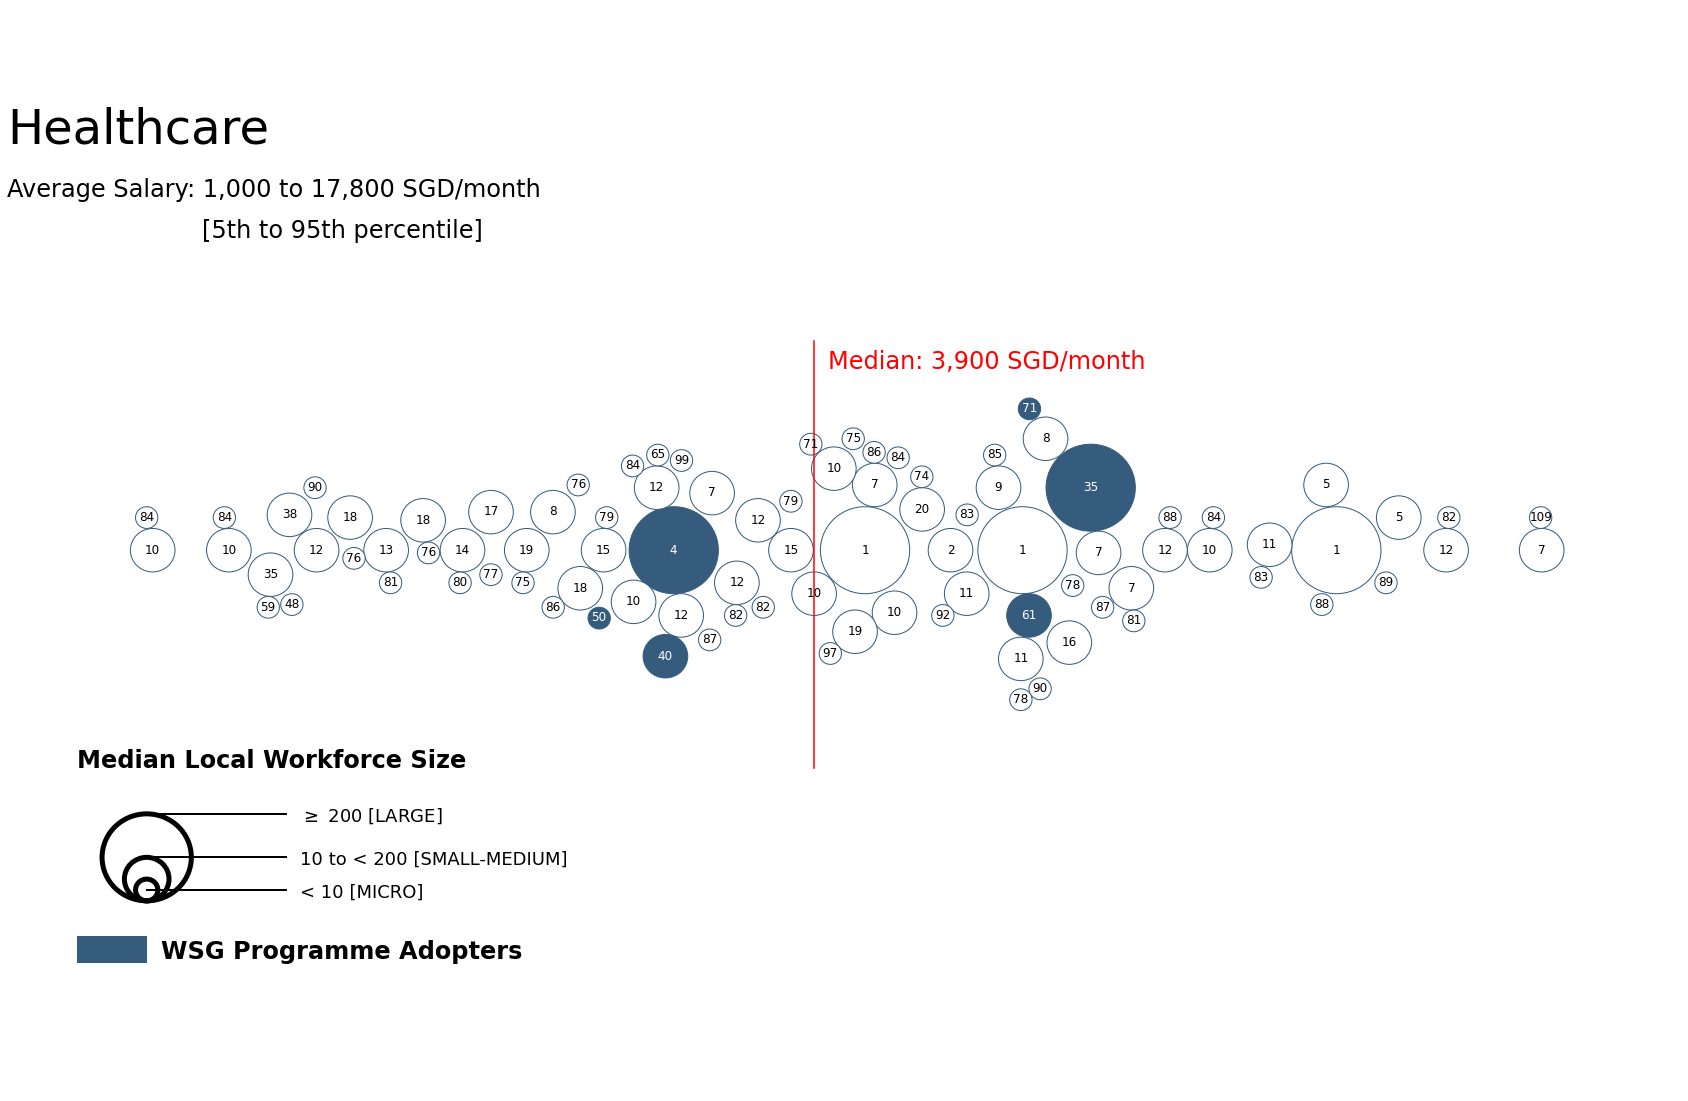

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


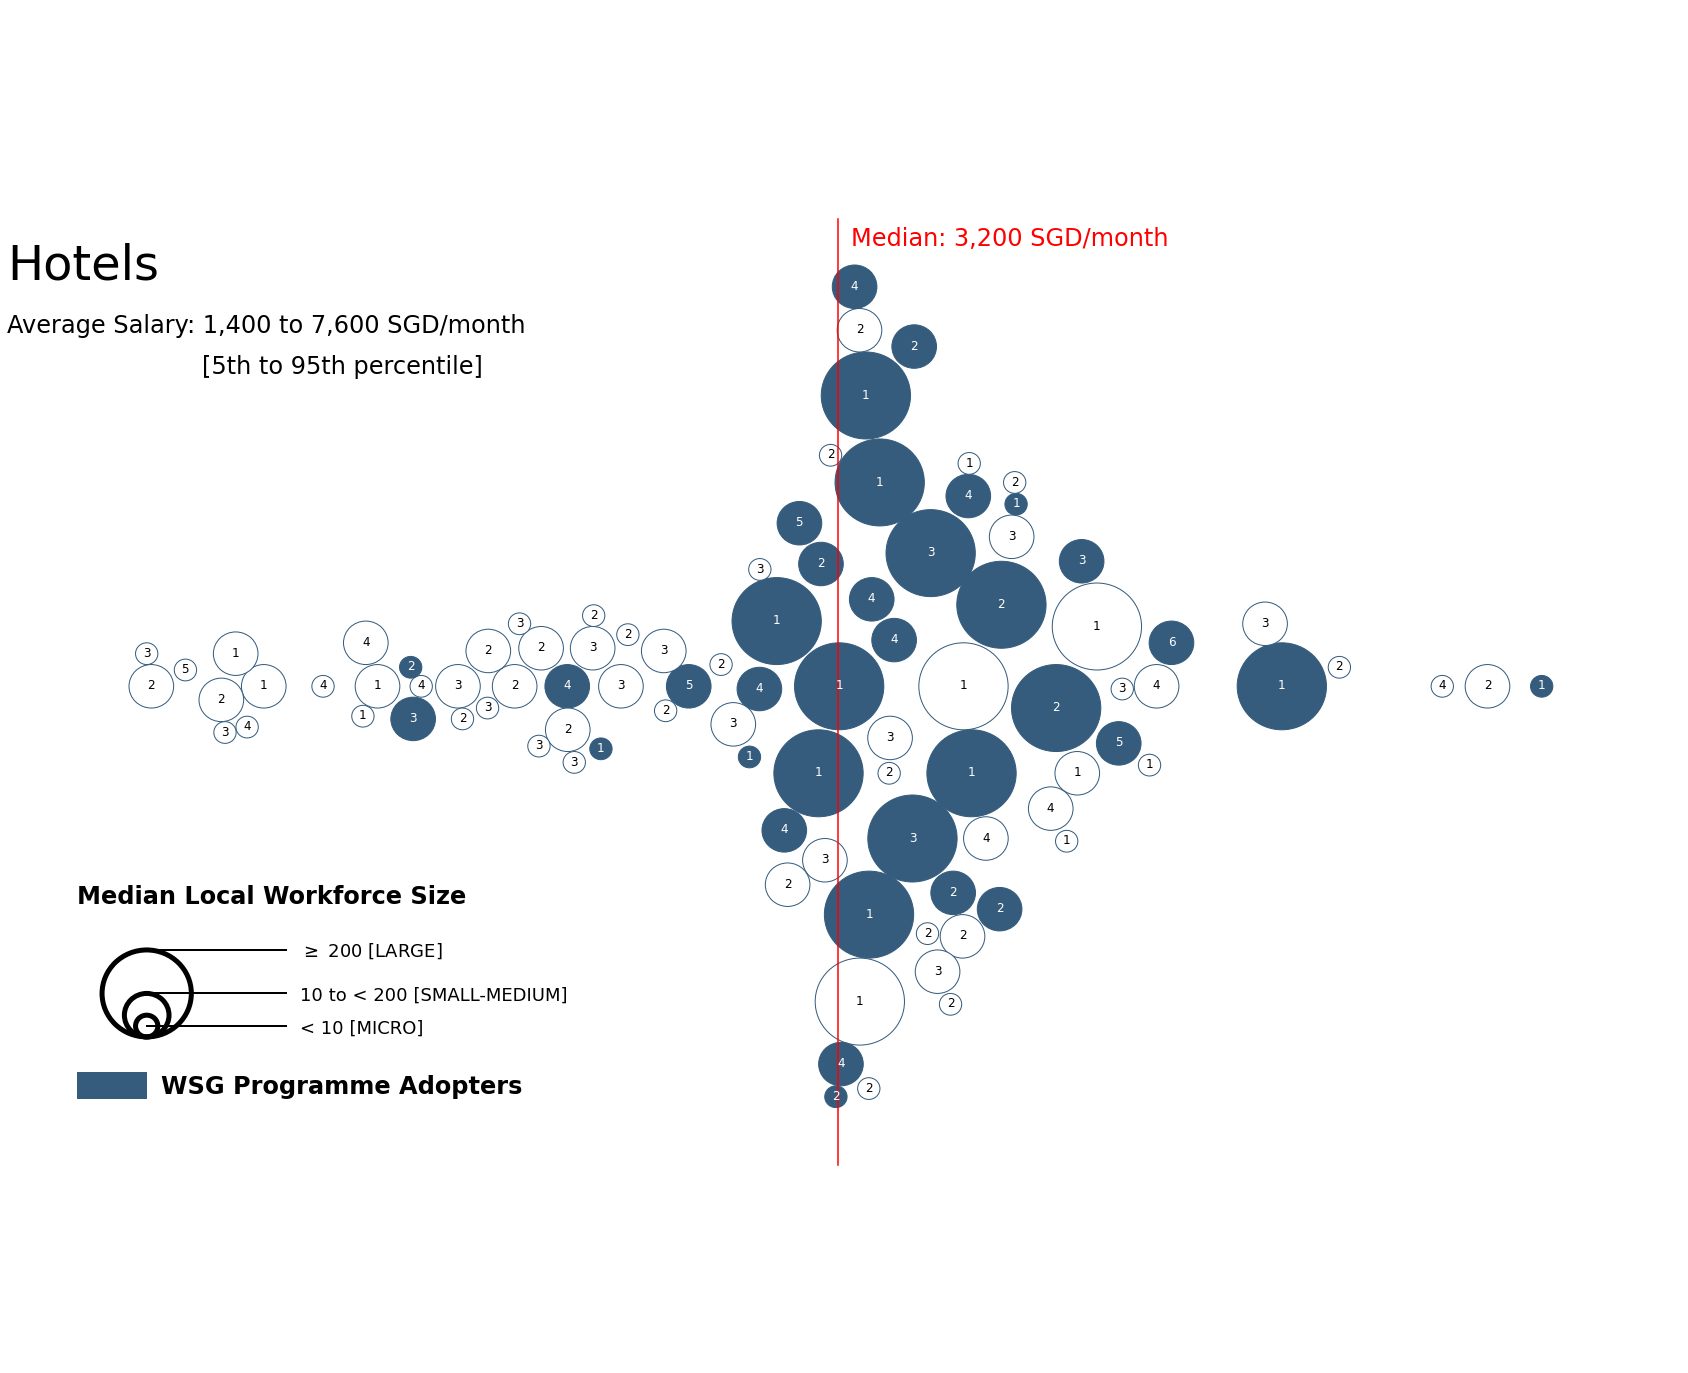

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


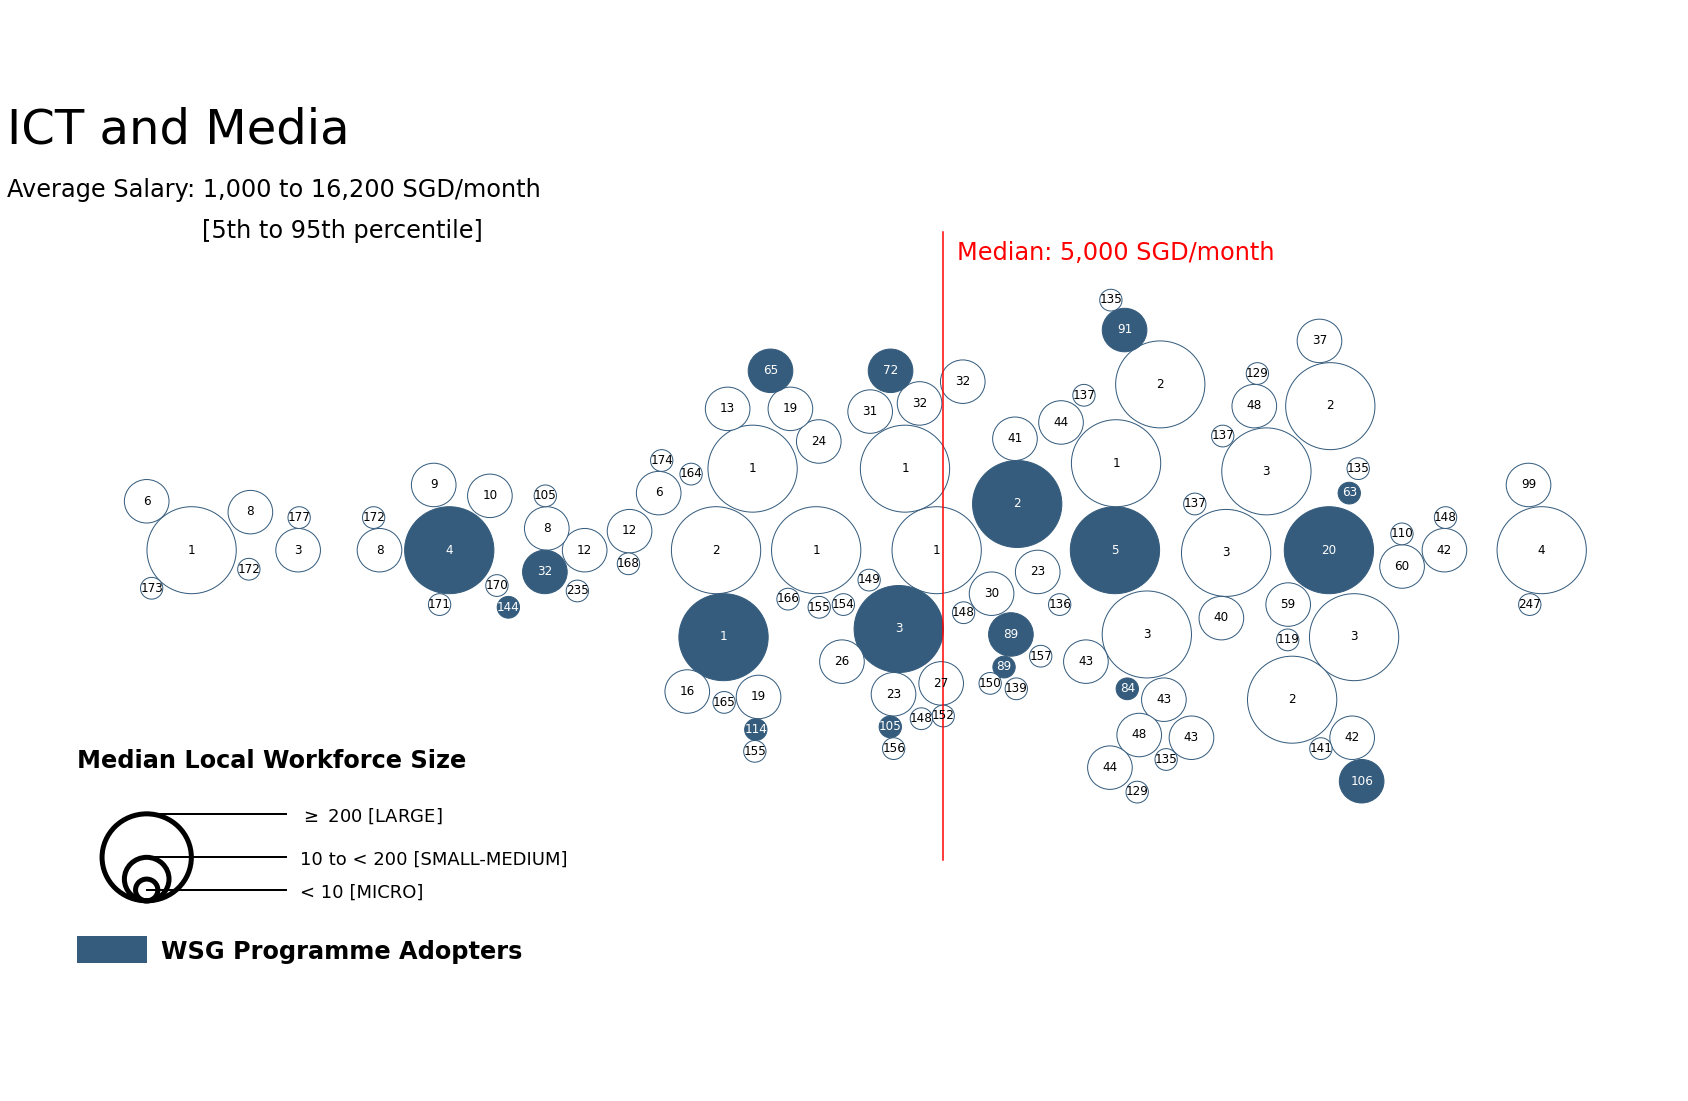

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


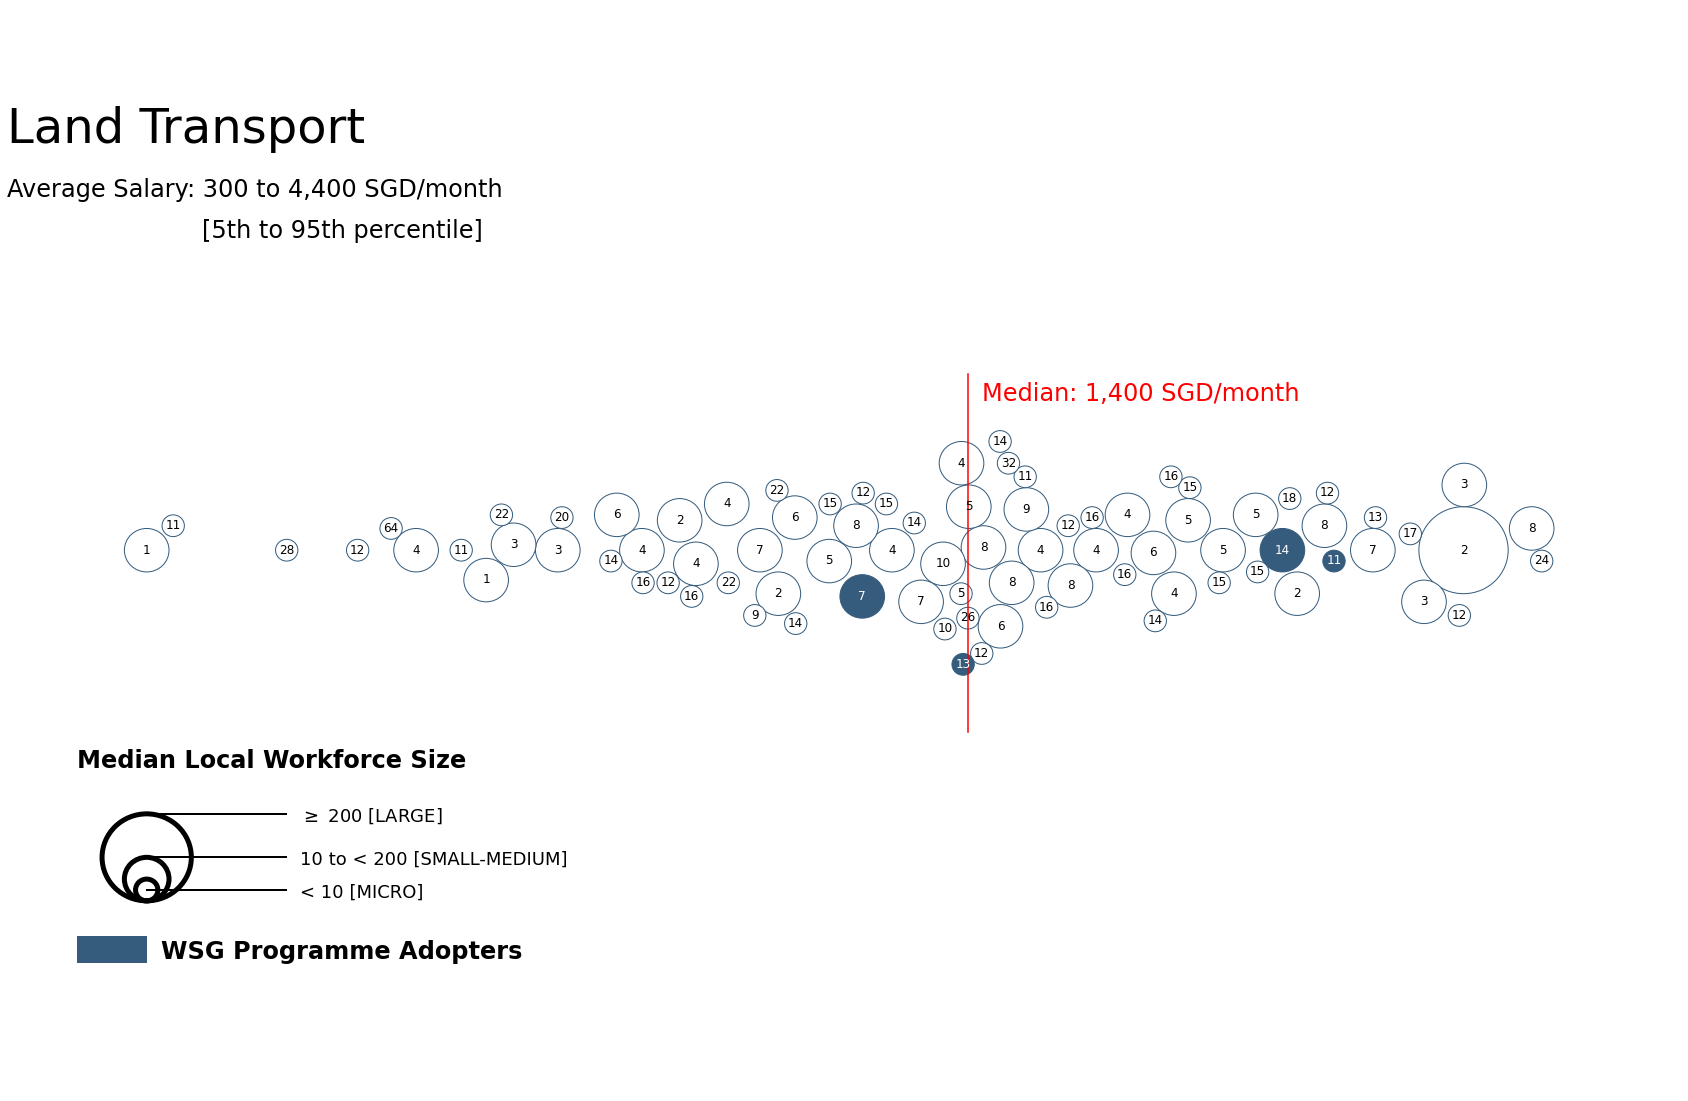

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


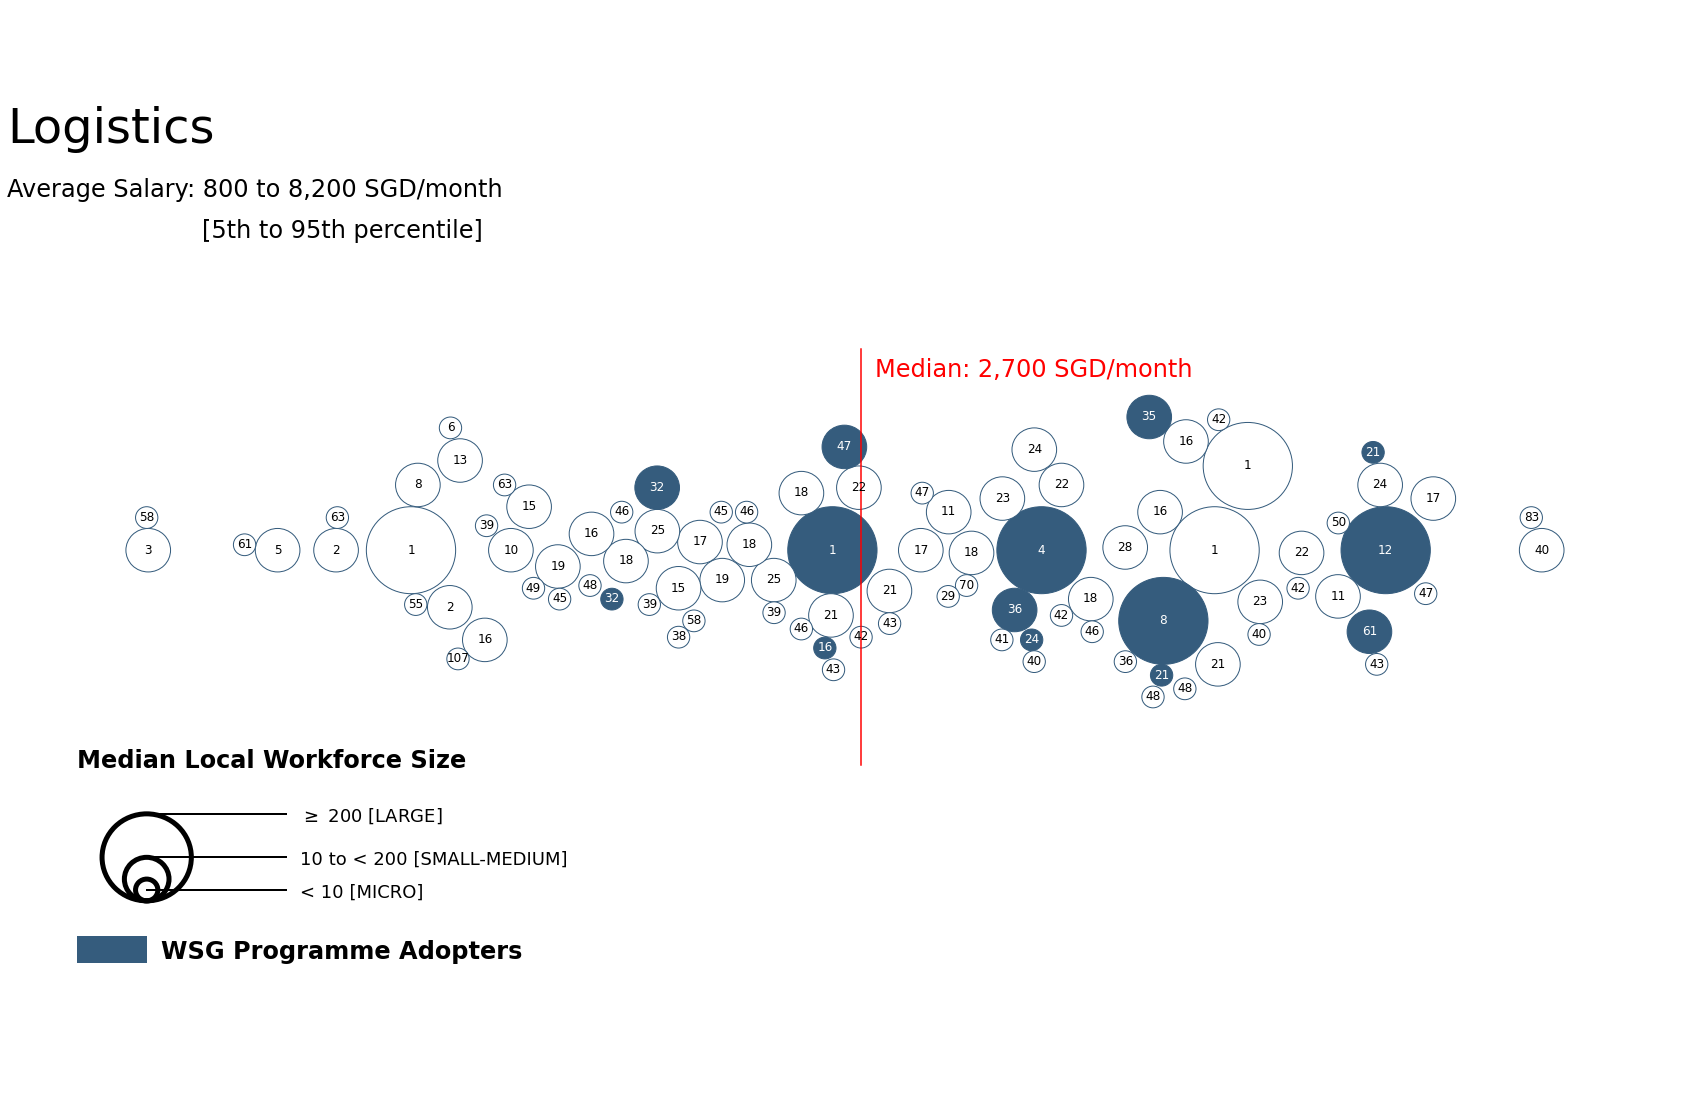

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


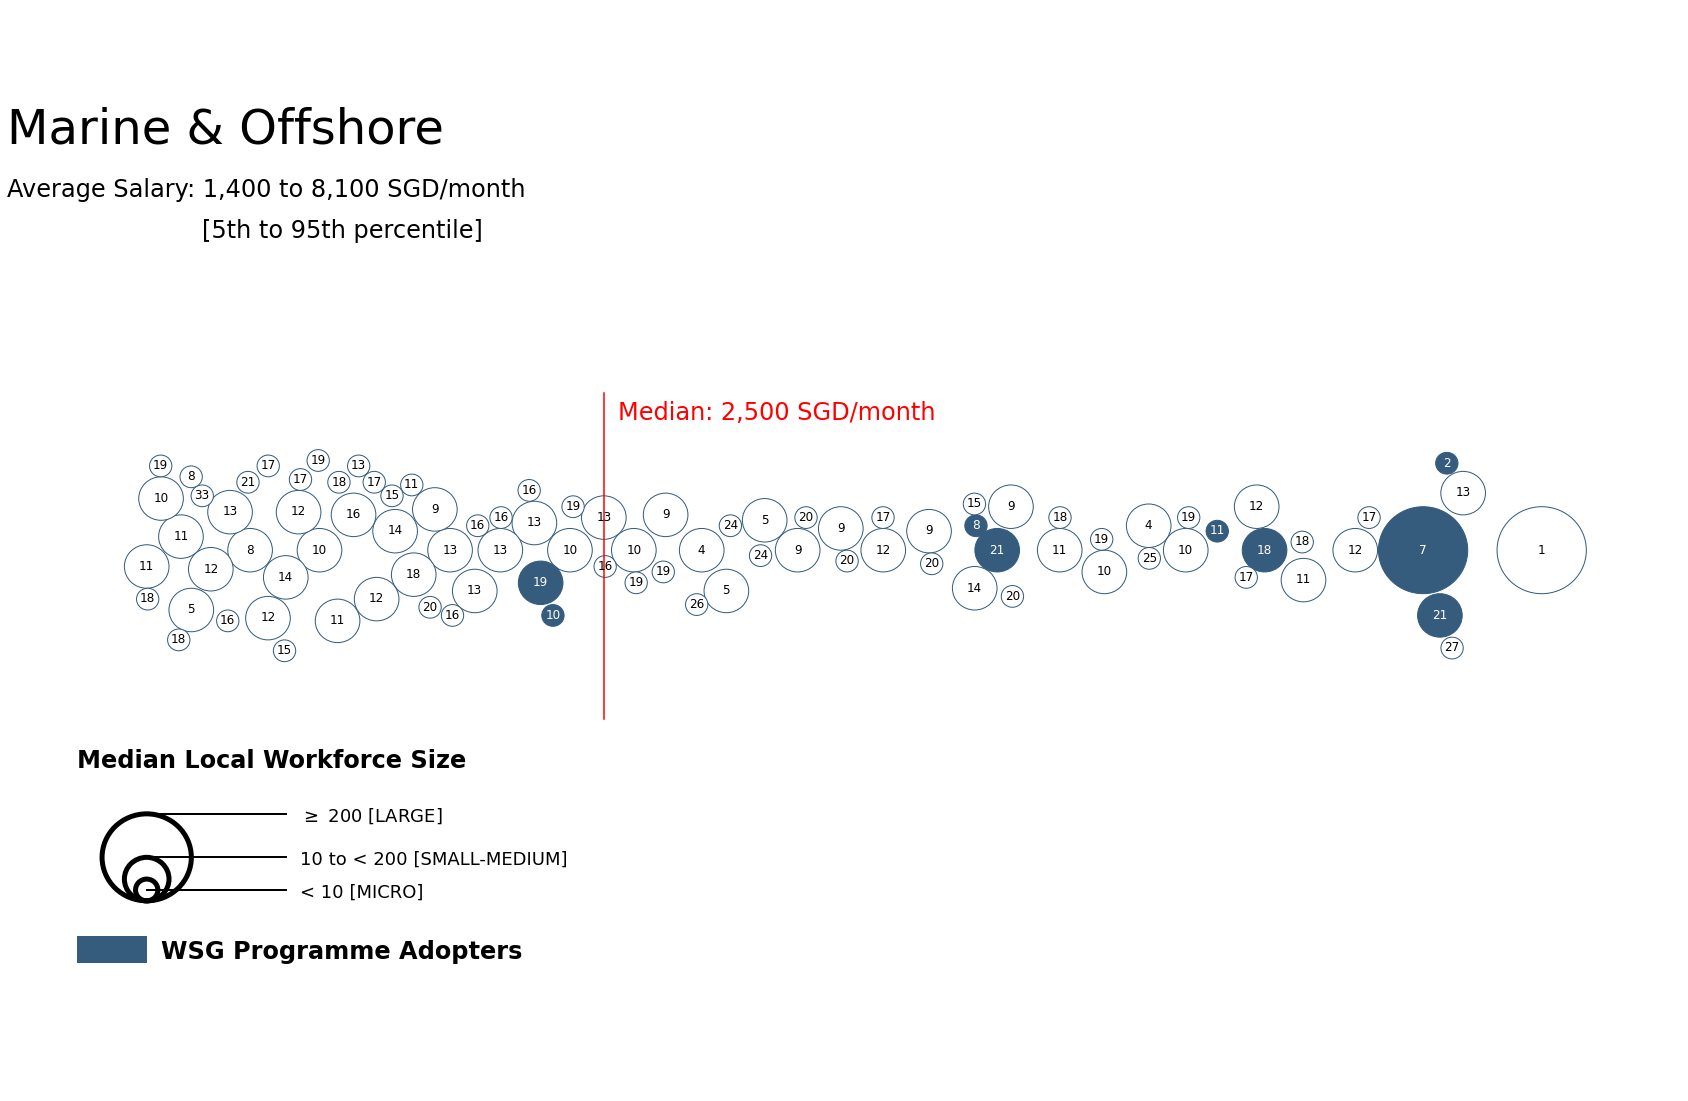

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


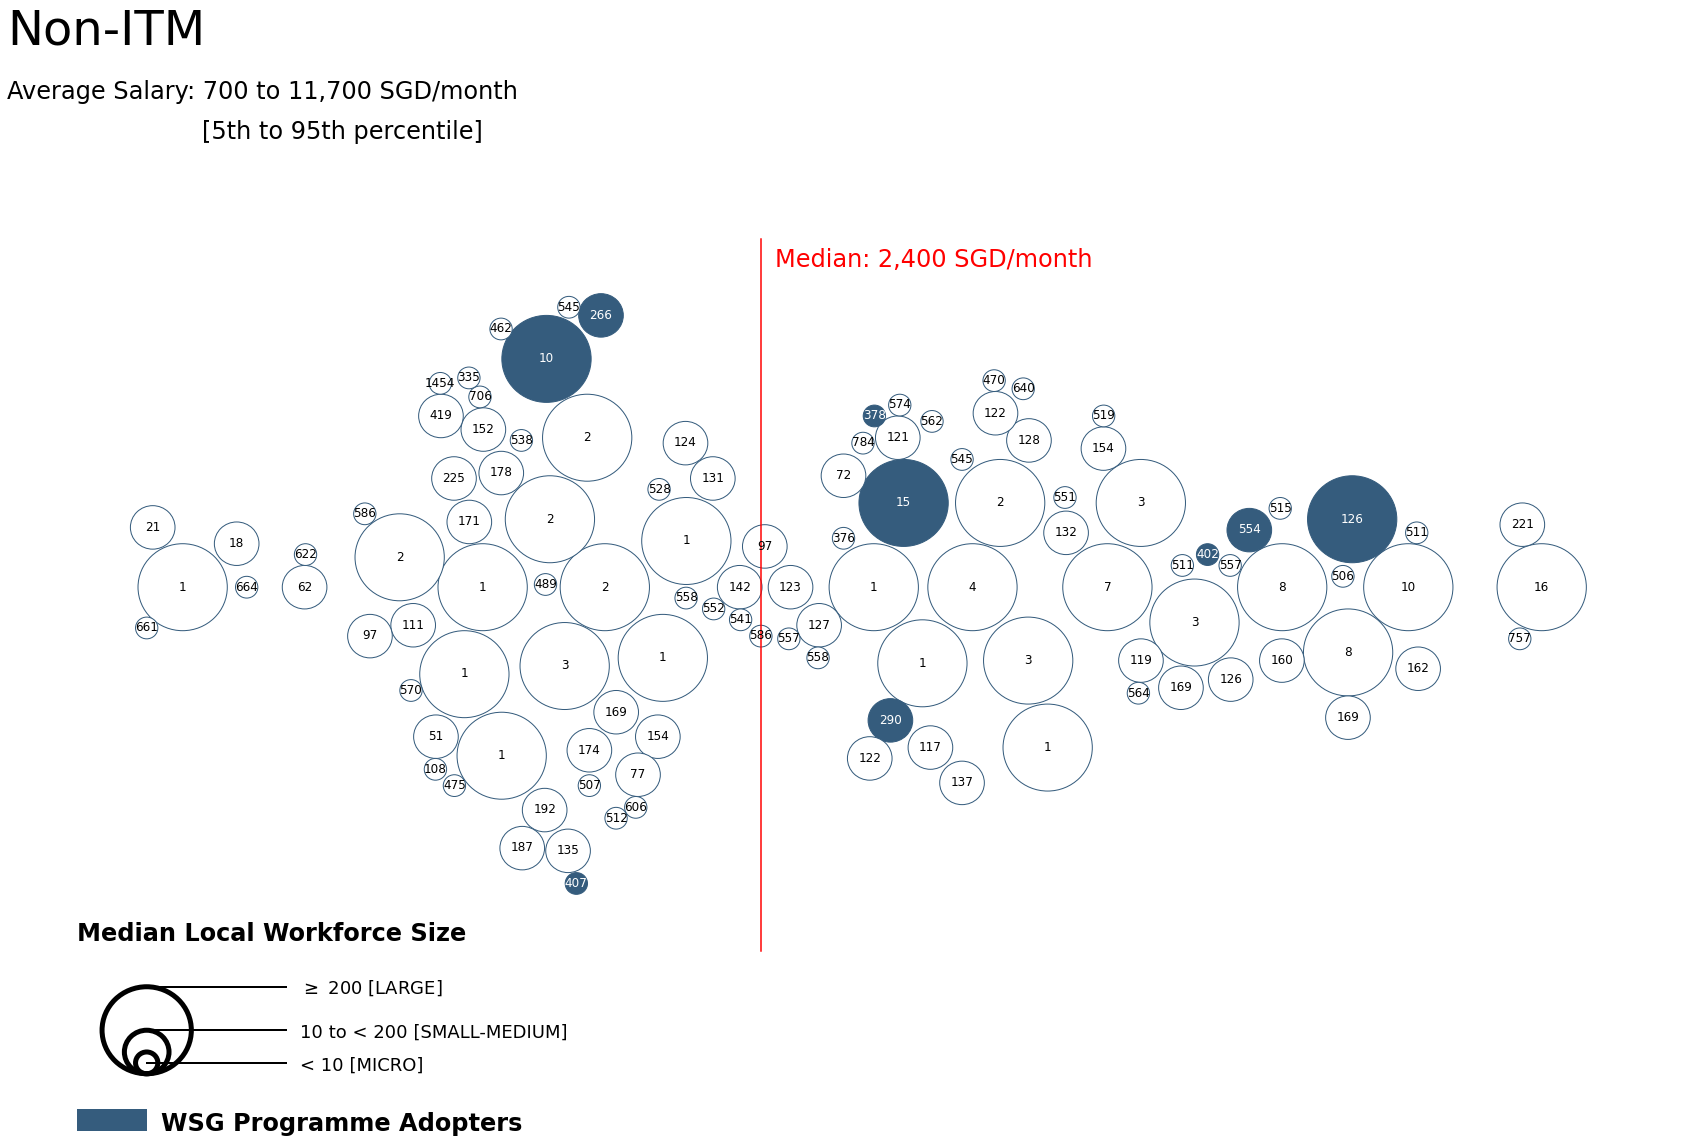

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


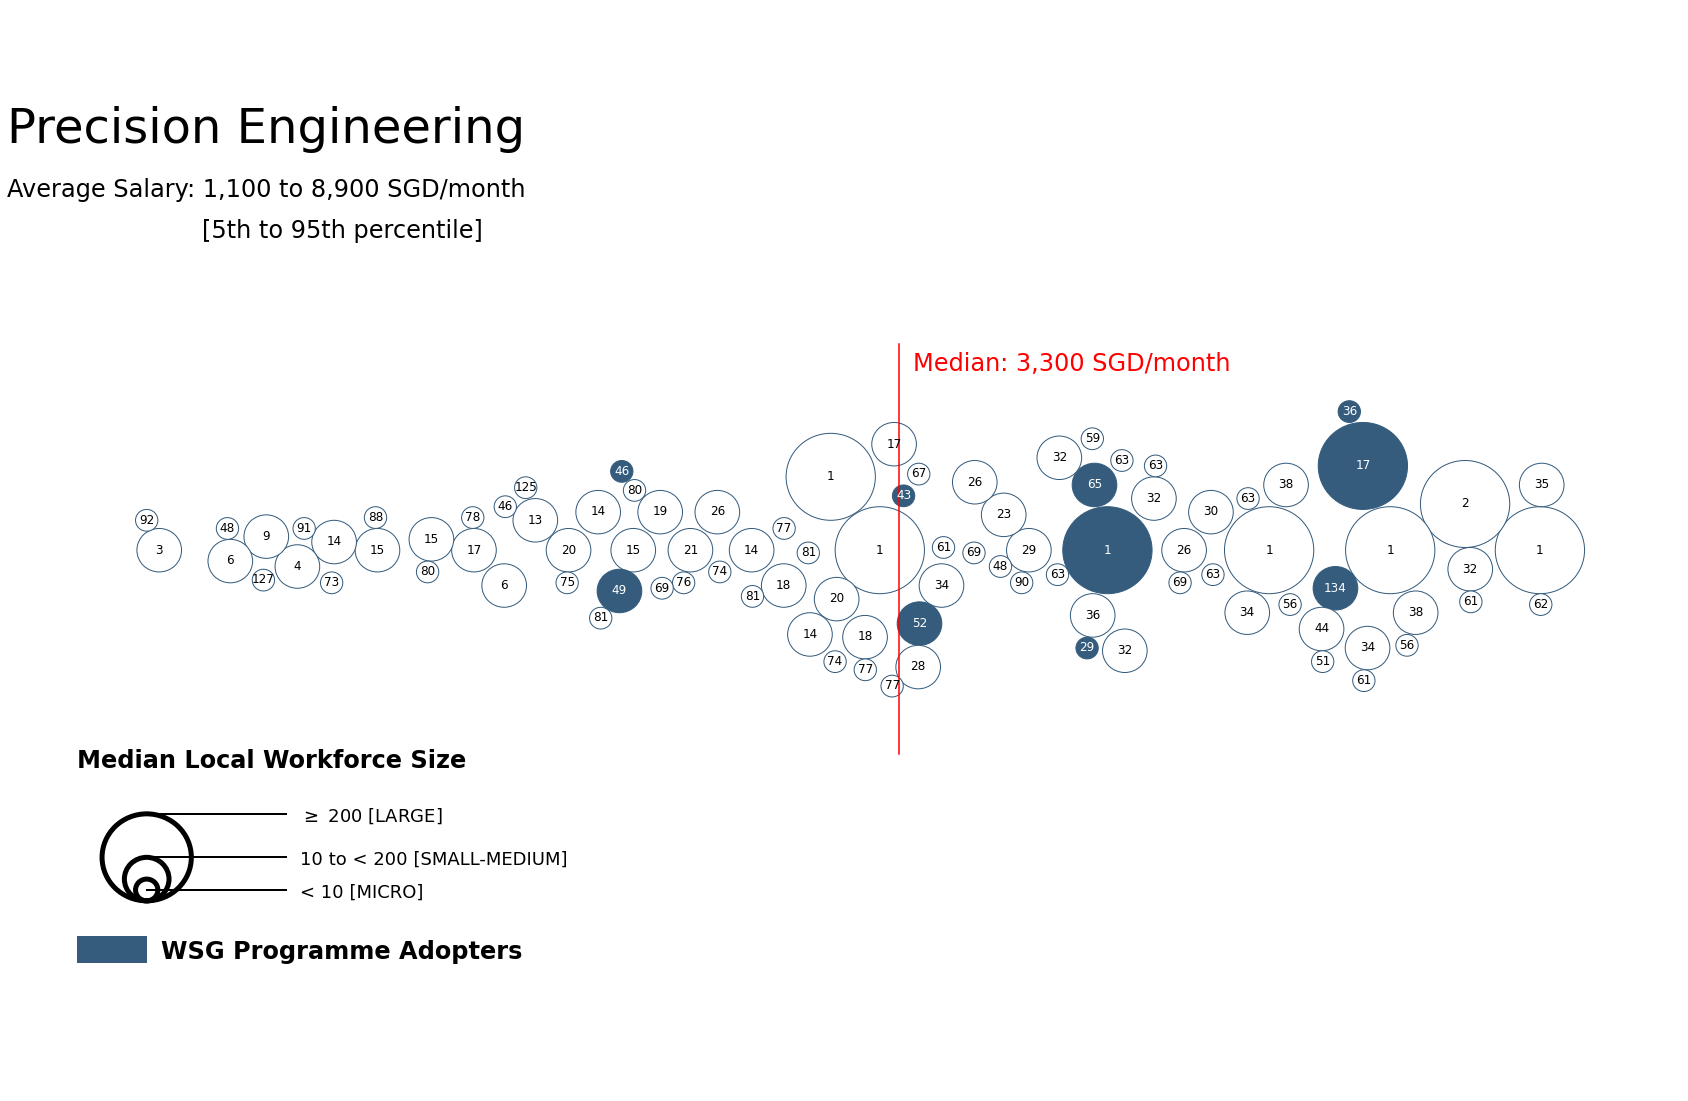

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


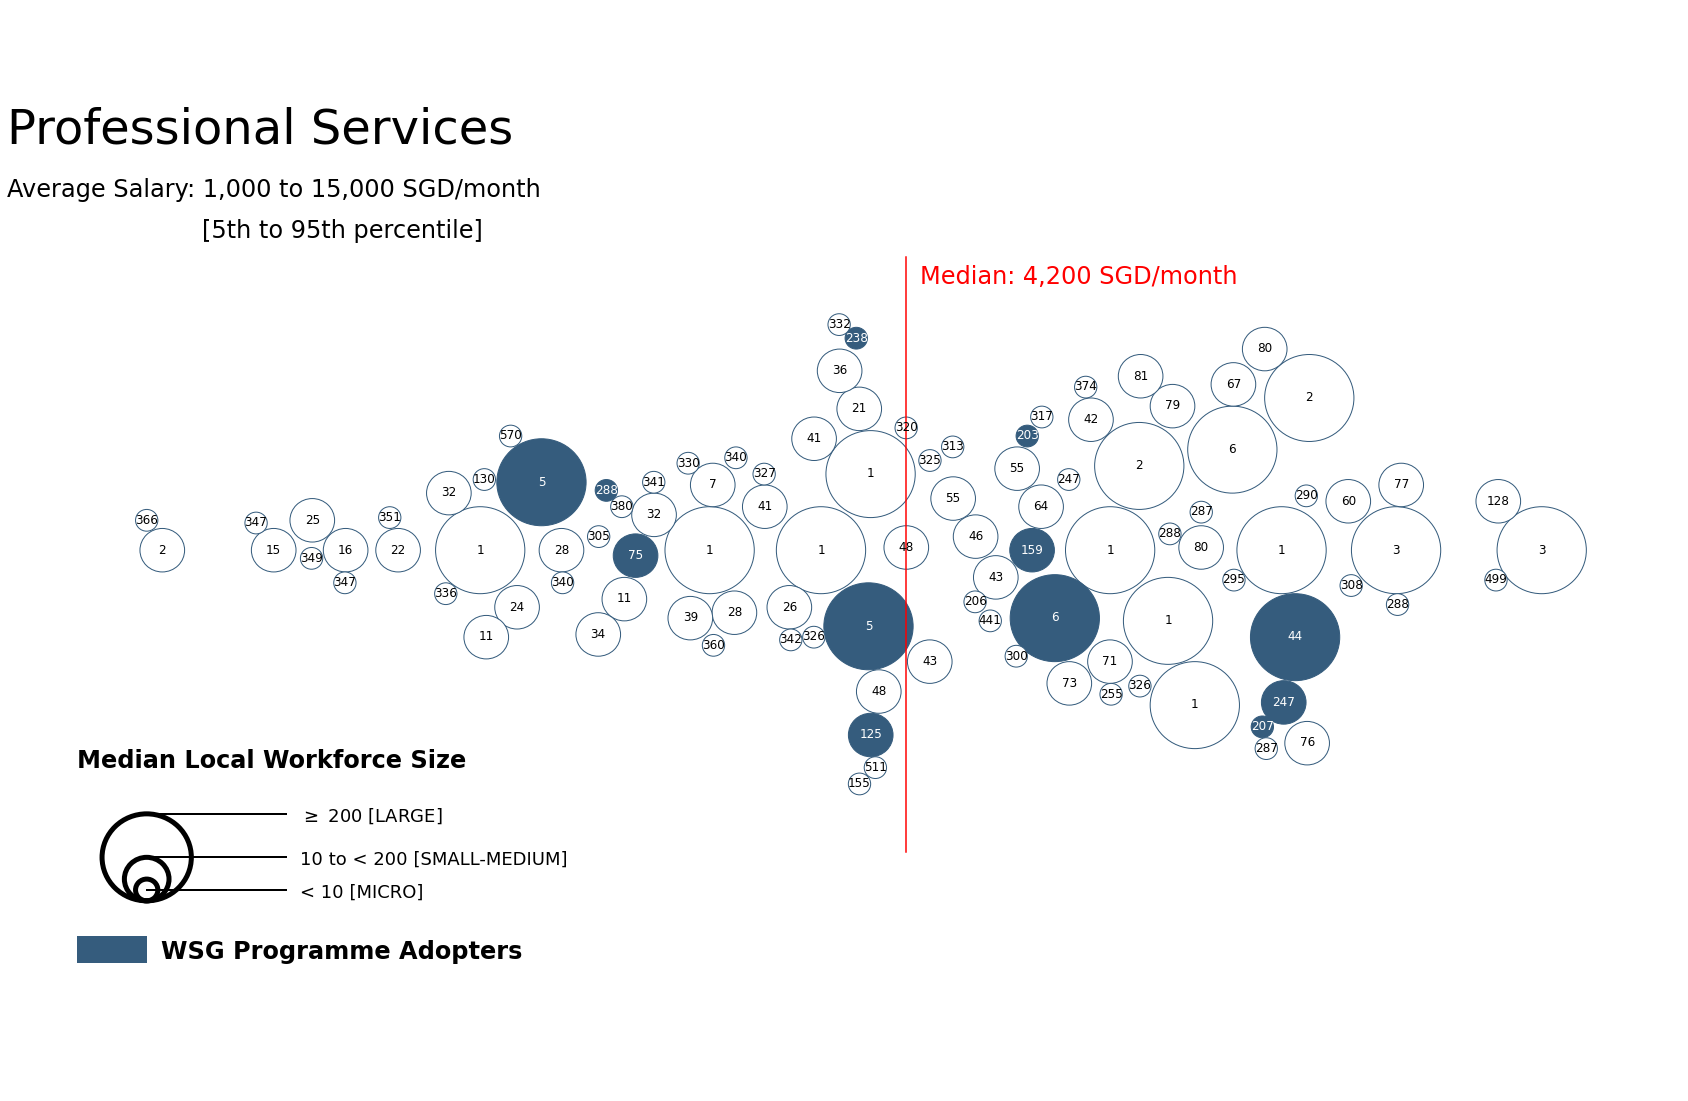

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


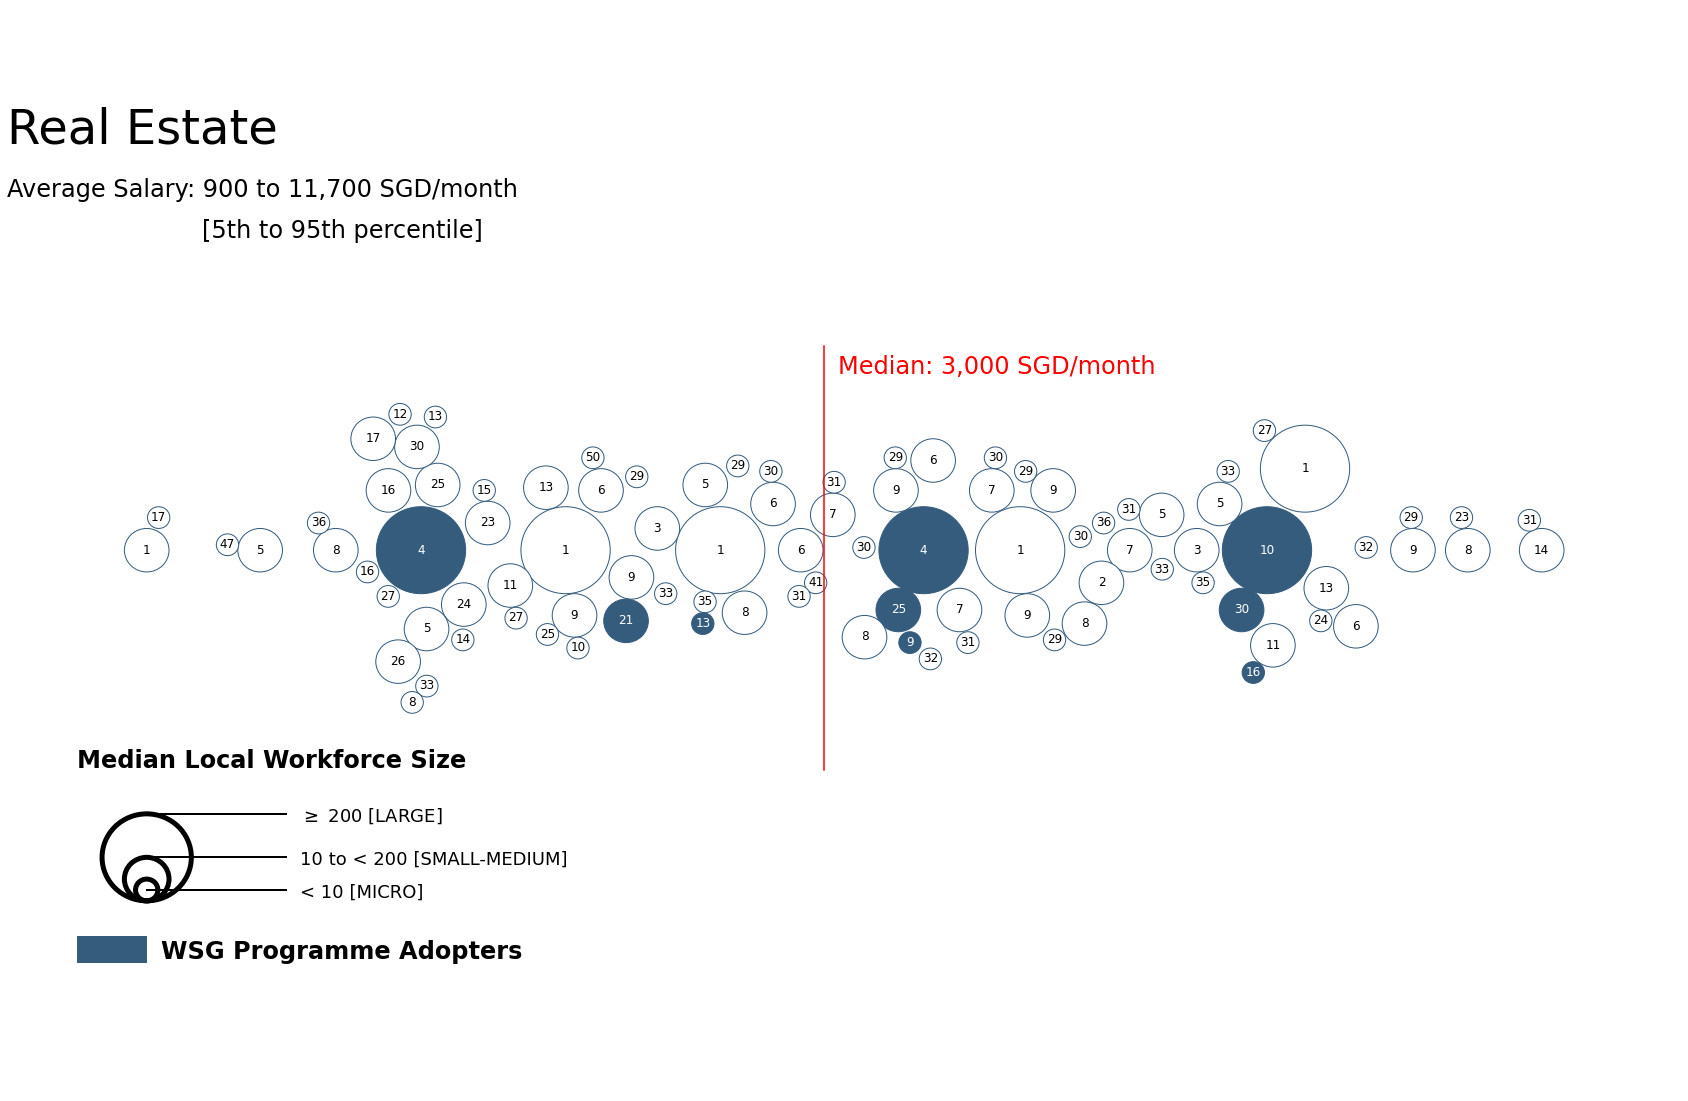

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


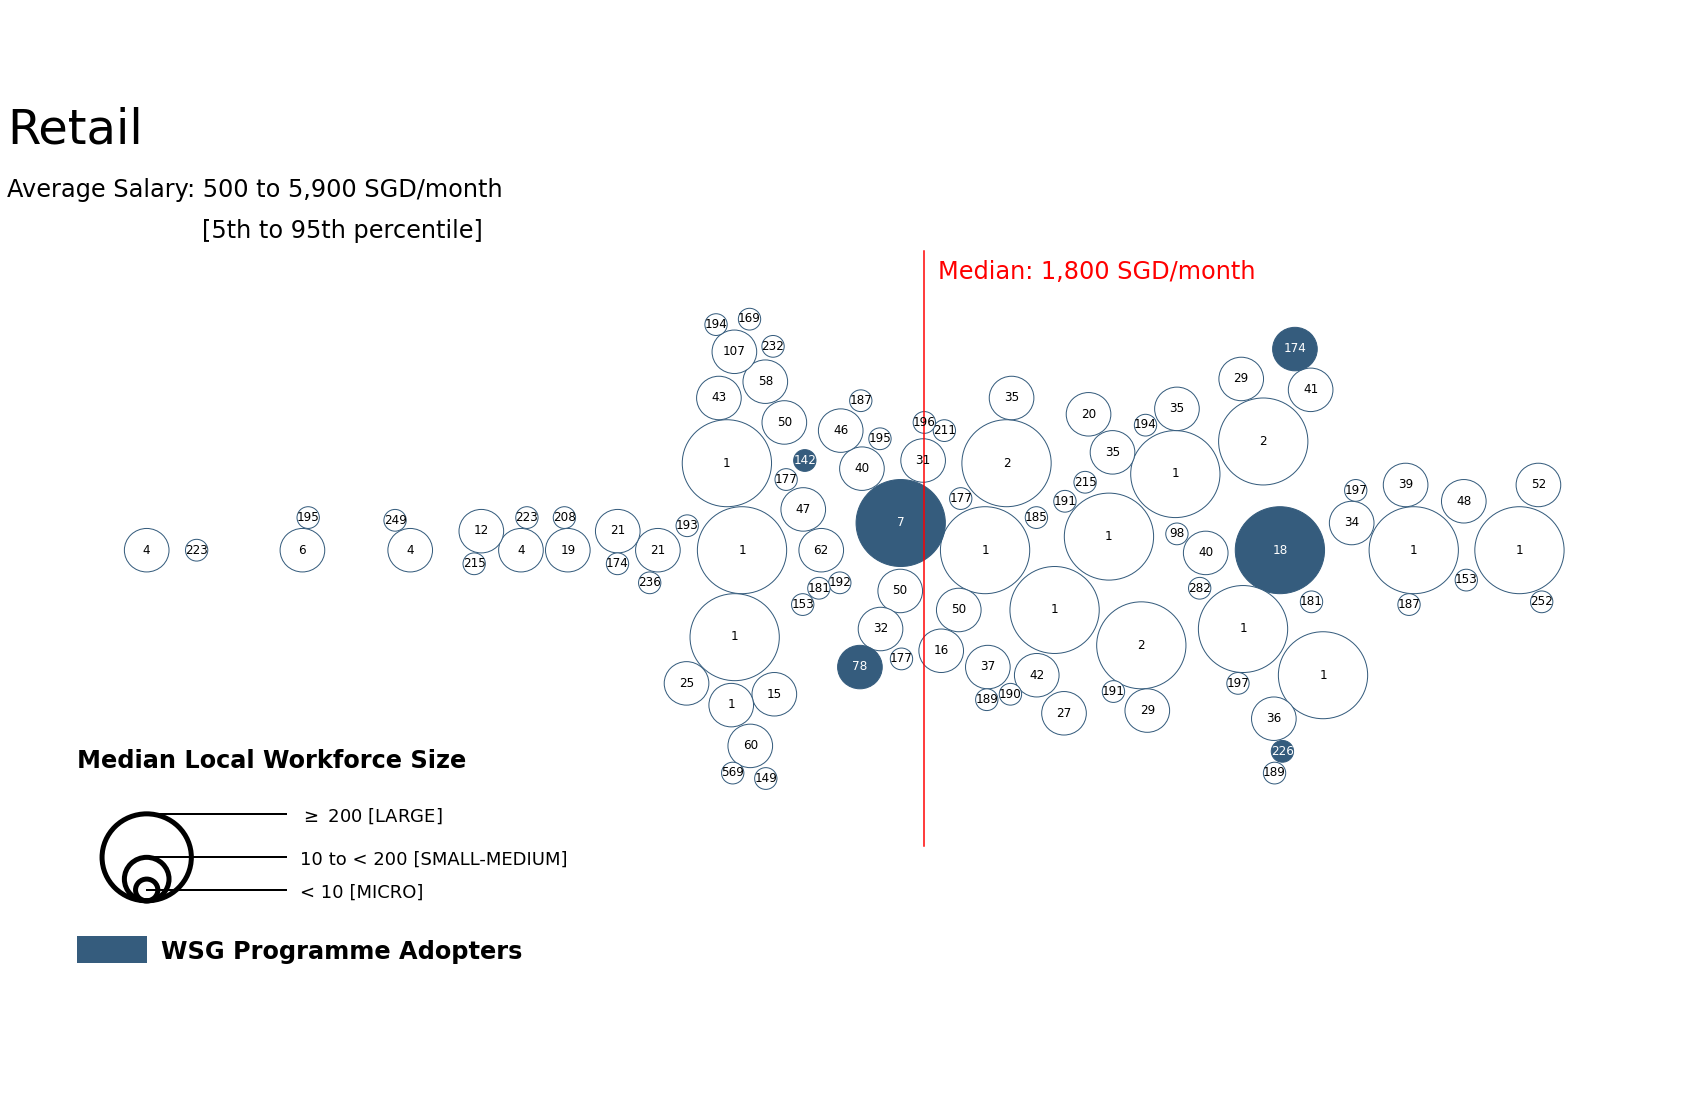

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


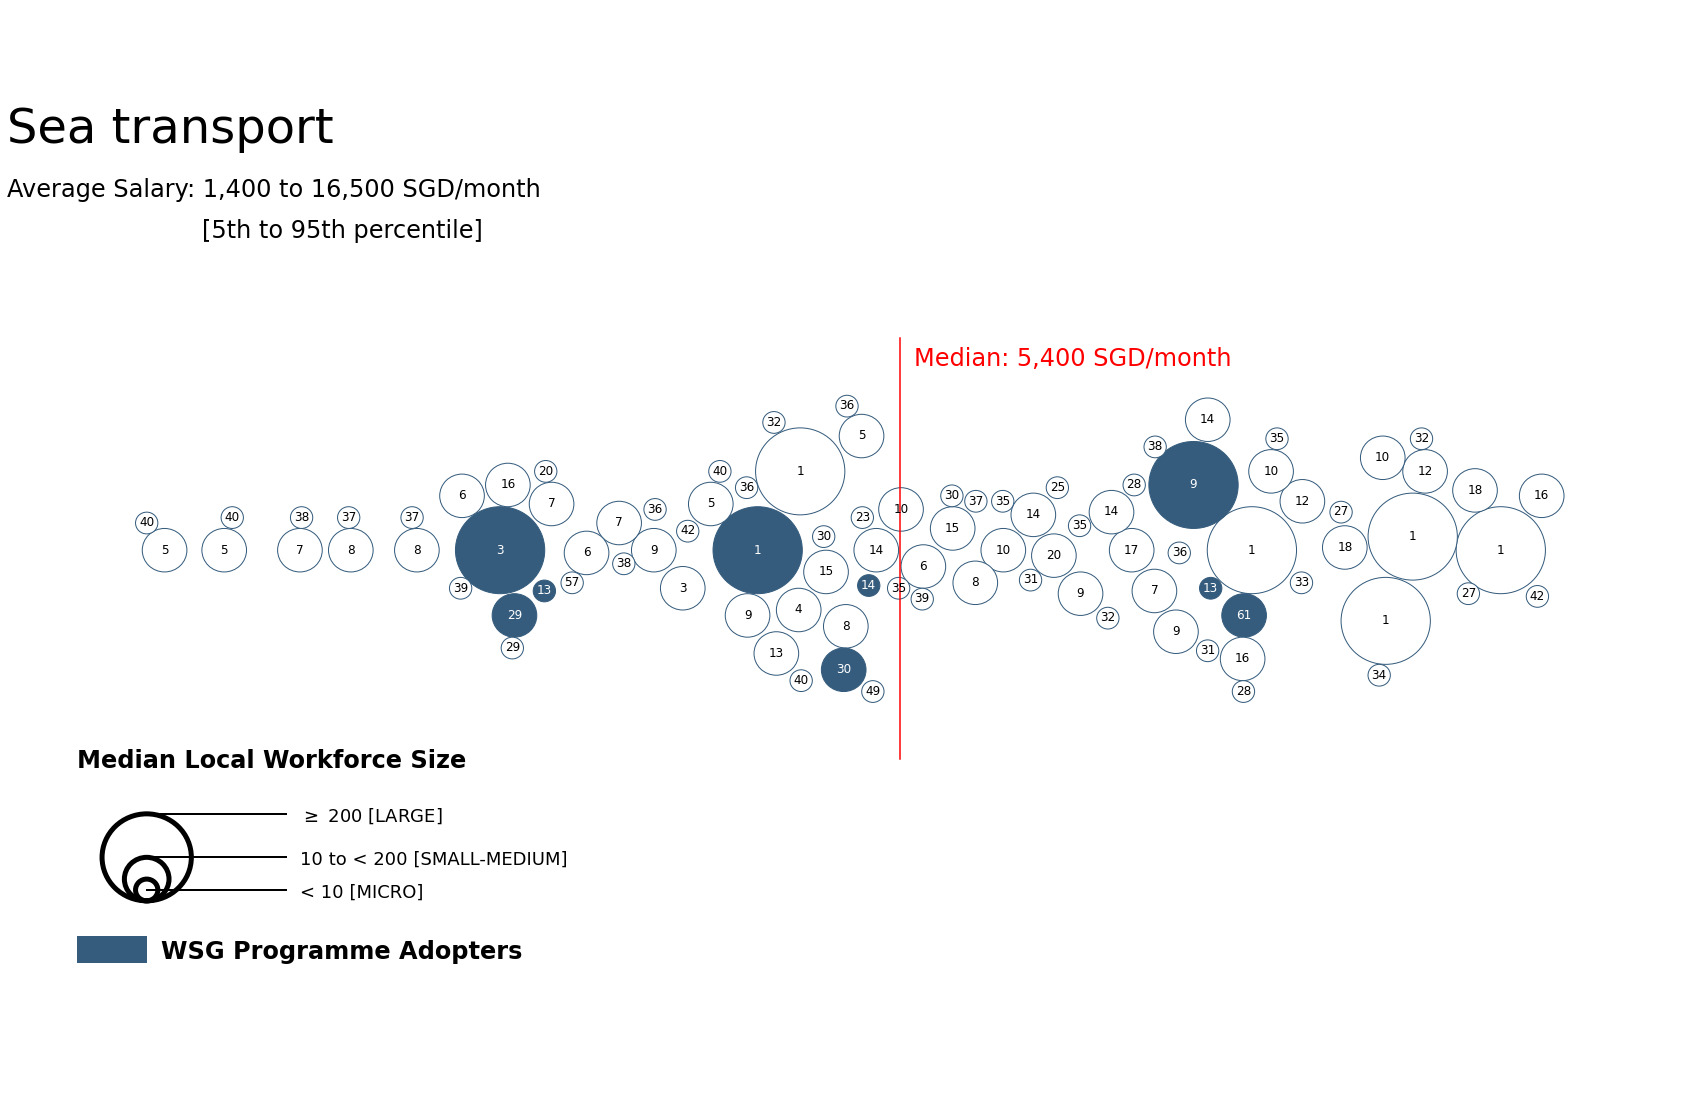

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


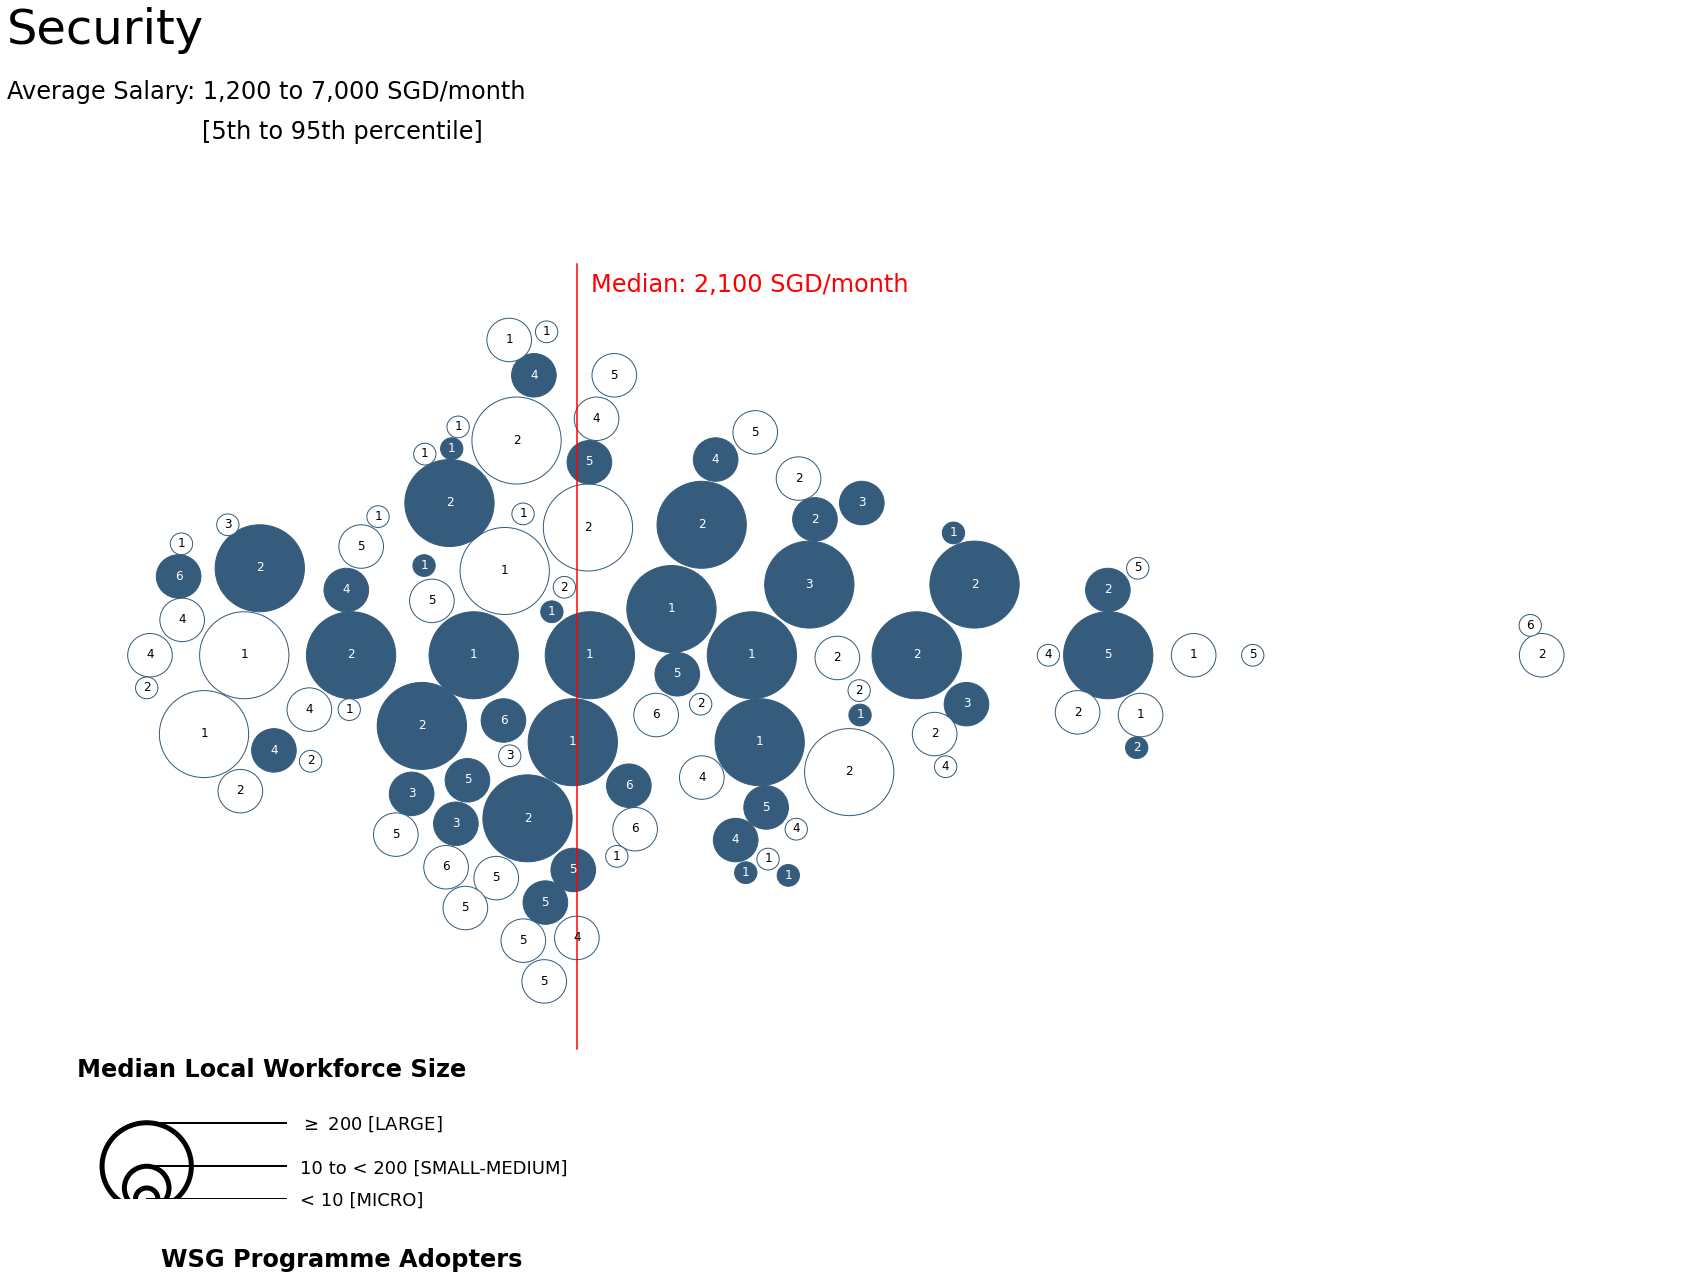

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


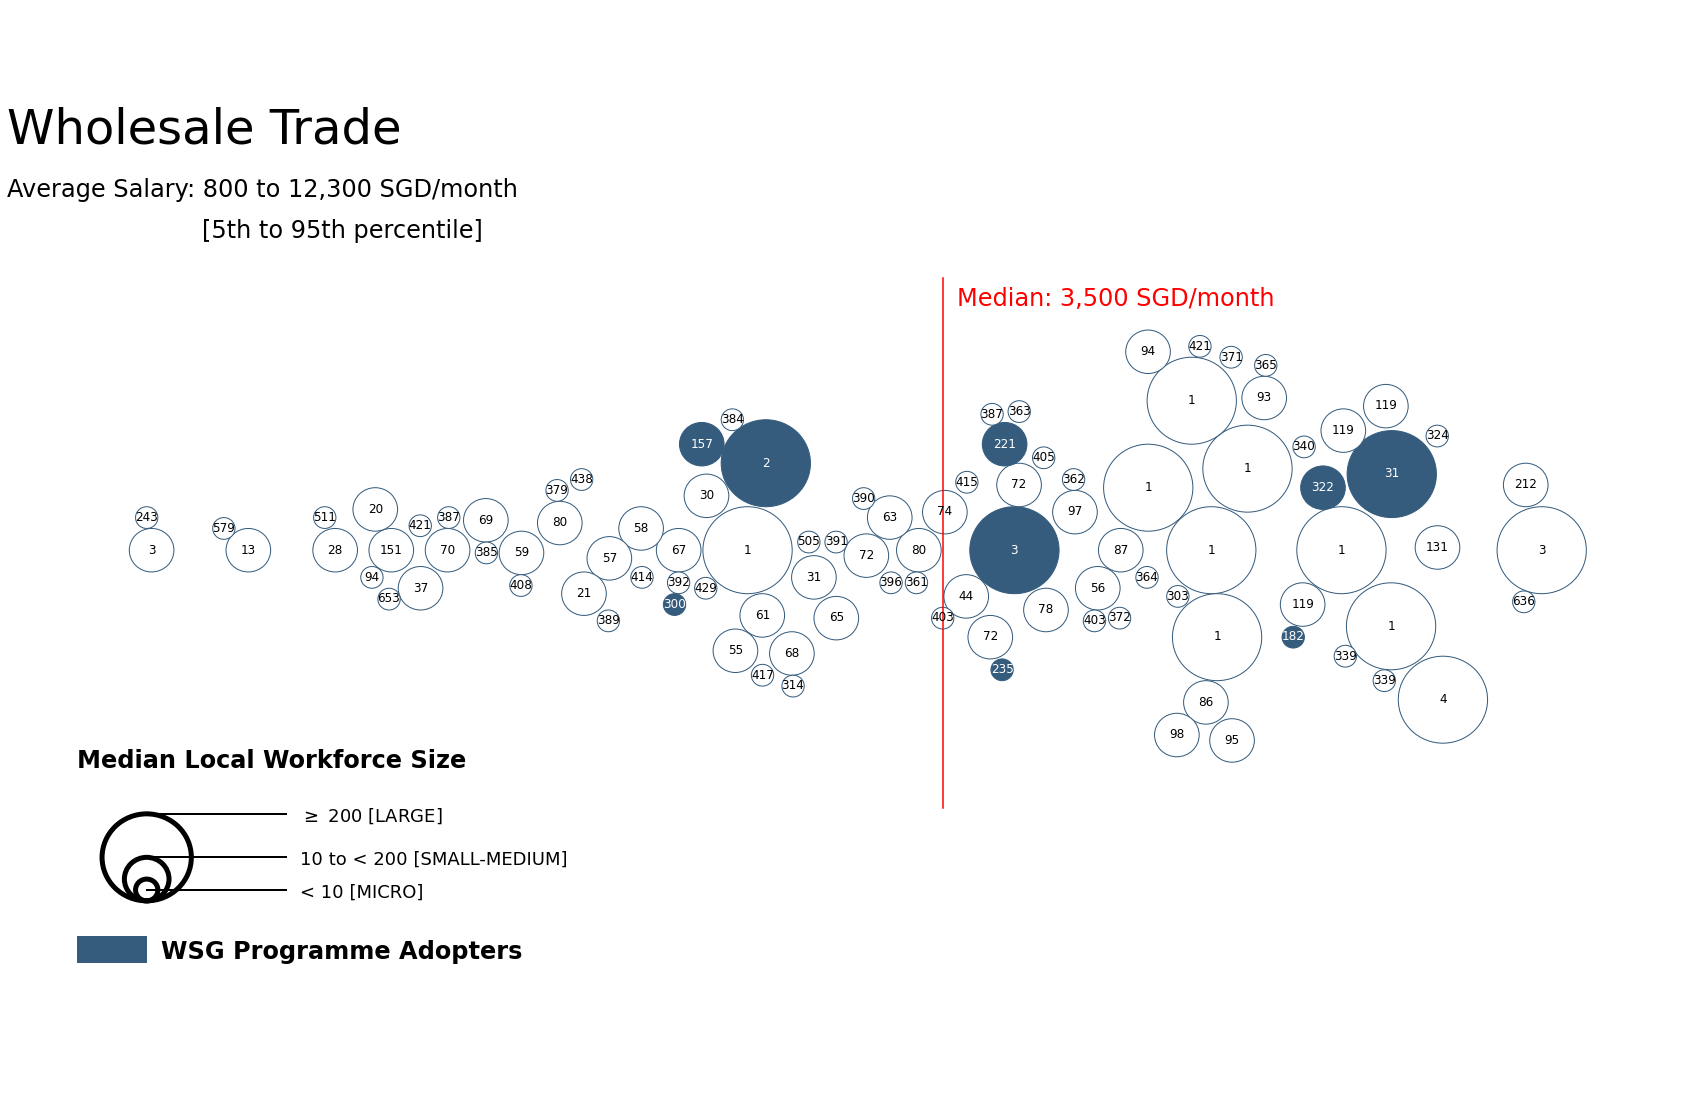

In [10]:
ITMs = np.unique(master_df['ITM'])

for ITM in ITMs:
    extract_df = master_df[(master_df['ITM'] == ITM) & (master_df[source_cols['x-coordinate']] > 0)].reset_index()
    # filter 5th to 95th percentile
    temp_df = extract_df[(extract_df[source_cols['x-coordinate']] > extract_df[source_cols['x-coordinate']].quantile(0.05)) &
                         (extract_df[source_cols['x-coordinate']] < extract_df[source_cols['x-coordinate']].quantile(0.95))].reset_index()
    # recode size column
    conditions = [
        (temp_df[source_cols['size']] == dimensions['size'][0]),
        (temp_df[source_cols['size']] == dimensions['size'][1]),
        (temp_df[source_cols['size']] == dimensions['size'][2])
        ]
    temp_df['radius'] = np.select(conditions, radii)
    
    # isolate x-coordinate, size, color in all_circles
    if len(temp_df) < 225:
        ix = np.argsort(temp_df['radius'])[::-1]
        all_circles = np.zeros((len(temp_df), 4))
        all_circles[:,0] = temp_df[source_cols['x-coordinate']][ix]
        all_circles[:,2] = temp_df['radius'][ix]
        all_circles[:,3] = temp_df[source_cols['color']][ix]

        labels = np.ones((len(all_circles),1))
        
    # need to preprocess the larger sectors to bin by similar x-coordinate x size x color profiles
    else:
        ix = np.argsort(temp_df[source_cols['x-coordinate']])
        all_circles = np.zeros((len(temp_df), 4))
        all_circles[:,0] = temp_df[source_cols['x-coordinate']][ix]
        all_circles[:,2] = temp_df['radius'][ix]
        all_circles[:,3] = temp_df[source_cols['color']][ix]

        all_circles, labels = condense(all_circles, int(len(all_circles)/45))
        ix = np.argsort(all_circles[:,2])[::-1]
        all_circles = all_circles[ix]
        labels = labels[ix]
        
    all_circles[:,0] = np.log10(all_circles[:,0]) # log axis looks better!
    # normalize x-axis: 0 - 5
    x_max = max(all_circles[:,0])
    x_min = min(all_circles[:,0])
    all_circles[:,0] = 5*(all_circles[:,0] - x_min) / (x_max - x_min)
    
    # separate color column
    c_color = all_circles[:,3].reshape(len(all_circles),1)
    # all_circles now contains only (x,y,r) of each circle to be plotted
    all_circles = all_circles[:,0:3]
    
    # compute y-coordinate for each circle
    for ir, row in enumerate(all_circles):
        x_curr, y_curr, r_curr = row
        if ir > 0:
            existing_circles = all_circles[0:ir,:]
            all_circles[ir,1] = compute_ycoord(x_curr, r_curr, existing_circles)
    
    #### VISUALIZE ON PYTHON #####
        
    # set y-limits for figure based on max y-coordinates
    ylims = [round(min(all_circles[:,1] - 1)*2)/2,
             round(max(all_circles[:,1] + 1)*2)/2]
    ylims[0] = min(ylims[0],-2)
    ylims[1] = max(ylims[1],2)

    yres = (ylims[1] - ylims[0])*5
    fig = plt.figure(figsize = [30,yres])
    plt.xlim([-0.5, 5.5])
    plt.ylim(ylims)

    # plot each circle (x,y,r) -- color based on adoption status, label if circle is representing > 1 company
    for ii in range(0,len(all_circles)):
        circle1 = plt.Circle((all_circles[ii,0], all_circles[ii,1]), all_circles[ii,2],
                             edgecolor = edge_color, facecolor = fill_colors[int(c_color[ii])], linewidth = 1)
        plt.gca().add_artist(circle1)
        if max(labels) > 1:
            plt.gca().annotate(str(int(labels[ii])),
                               xy = (all_circles[ii,0],
                                     all_circles[ii,1]-0.01),
                               fontsize = 12,
                               ha = 'center',
                               color = label_colors[int(c_color[ii])])

    # set limits for text surrounding figure (i.e. title and legend)
    if ITM == "Non-ITM":
        textlims = 1.5
    elif ITM == "Security":
        textlims = 1.75
    else: textlims = 1

    # add title, subtitle
    plt.text(-0.5, textlims+0.5, ITM, fontsize = 48)
    subtitle = 'Average Salary: {:,} to {:,} SGD/month'.format(round(min(temp_df['Average_Salary'])/100)*100,
                                                               round(max(temp_df['Average_Salary'])/100)*100)
    plt.text(-0.5, textlims+0.3, subtitle, fontsize = 24)

    plt.text(0.20, textlims+0.15, '[5th to 95th percentile]', fontsize = 24)

    # add red line for median and corresponding label
    plt.plot([np.median(all_circles[:,0]), np.median(all_circles[:,0])],
             [min(all_circles[:,1])-0.25, max(all_circles[:,1])+0.25], color = 'red')
    plt.text(np.median(all_circles[:,0])+0.05, max(all_circles[:,1])+0.15, 'Median: {:,} SGD/month'.format(round(np.median(temp_df['Average_Salary'])/100)*100), color = 'red', fontsize = 24)

    # add legend (using function)
    plt = add_legend(plt, textlims)

    fig.patch.set_visible(False)
    plt.gca().axis('off')
    plt.show()